# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

In [1]:
# install package for displaying animation
#AT command line
#!sudo su
#!conda install -c conda-forge jsanimation 

In [1]:
from JSAnimation.IPython_display import display_animation

In [2]:
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

using device:  cpu


In [3]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



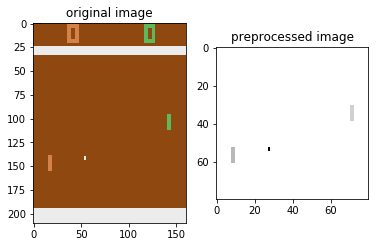

In [4]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()

# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ## https://github.com/tnakae/Udacity-DeepRL-PPO/blob/master/pong-REINFORCE.ipynb
    ## https://nbviewer.jupyter.org/github/tnakae/Udacity-DeepRL-PPO/blob/master/pong-REINFORCE.ipynb

        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # conv1 : 80 x 80 -> 40 x 40
        self.conv1 = nn.Conv2d(2, 4, kernel_size=2, stride=2)
        # conv2 : 40 x 40 -> 20 x 20
        self.conv2 = nn.Conv2d(4, 8, kernel_size=2, stride=2)
        # conv3 : 20 x 20 -> 10 x 10
        self.conv3 = nn.Conv2d(8, 16, kernel_size=2, stride=2)
        # conv4 : 10 x 10 ->  5 x  5
        self.conv4 = nn.Conv2d(16, 32, kernel_size=2, stride=2)
        self.size = 32 * 5 * 5
        
        # 1 fully connected layer
        self.fc1 = nn.Linear(self.size, 64)
        self.fc2 = nn.Linear(64, 8)
        self.fc3 = nn.Linear(8, 1)
        self.sig = nn.Sigmoid()
    ##
    ########
        
        
    def forward(self, x):
        
    ########
    ## 
    ## Modify your neural network
    # https://nbviewer.jupyter.org/github/tnakae/Udacity-DeepRL-PPO/blob/master/pong-REINFORCE.ipynb
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))

        x = x.view(-1, self.size)
        x = F.relu(self.fc1(x))  
        x = F.relu(self.fc2(x))  
        x = self.sig(self.fc3(x))
        return x
    ##
    ########

# run your own policy!
# policy=Policy().to(device)
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


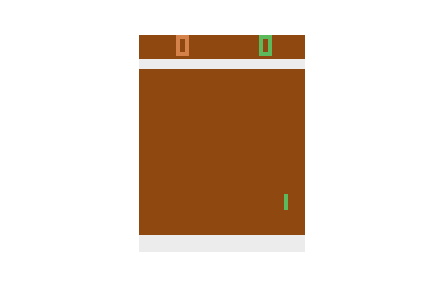
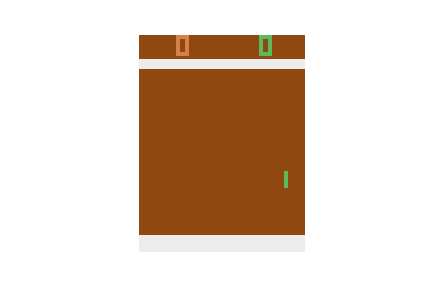
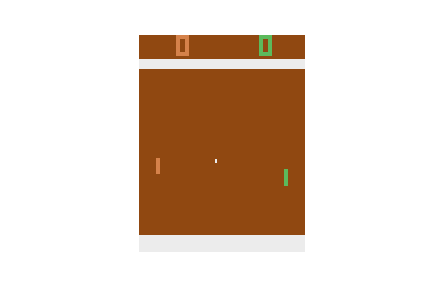
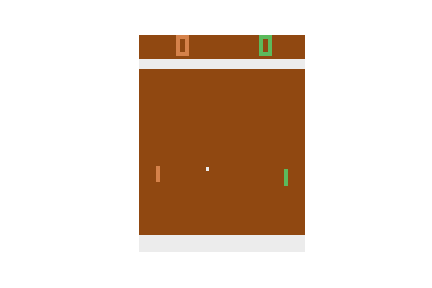
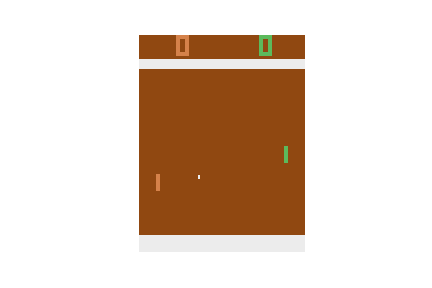
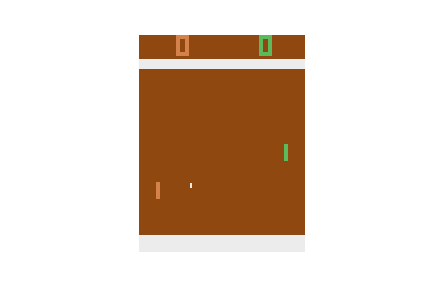
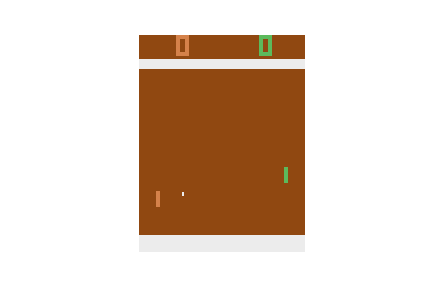
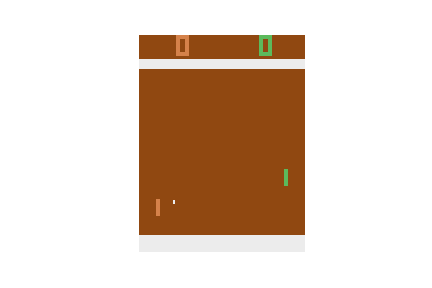
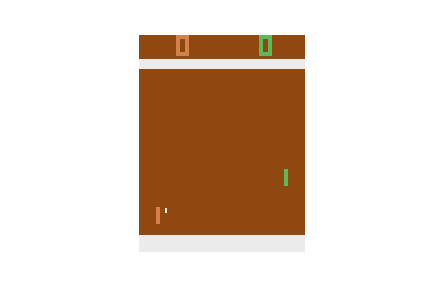
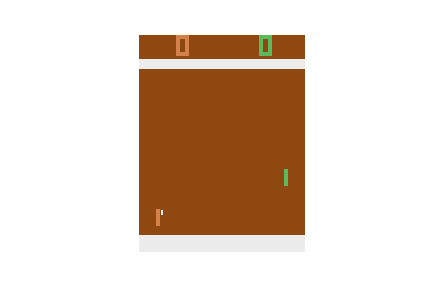
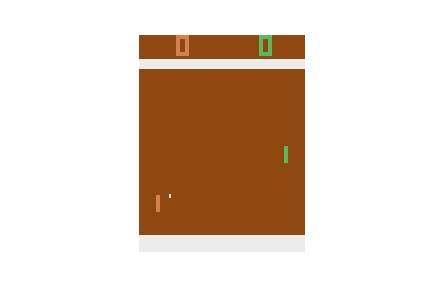
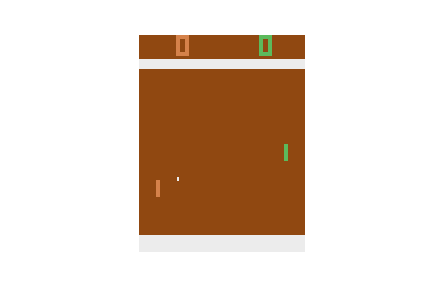
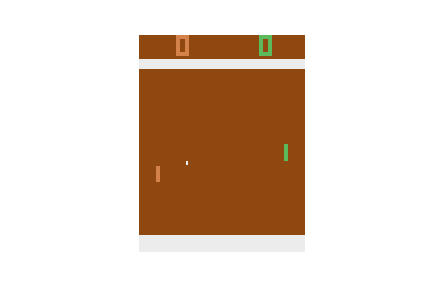
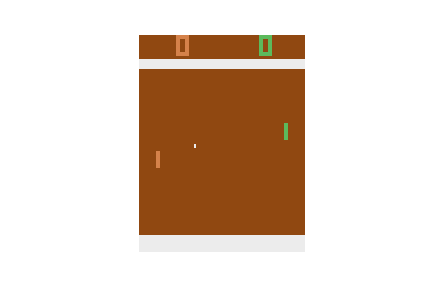
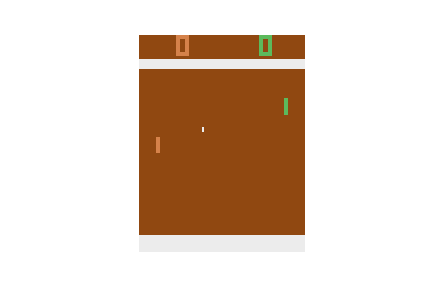
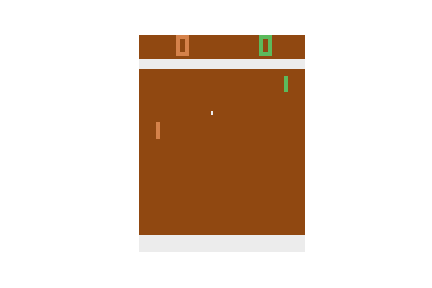
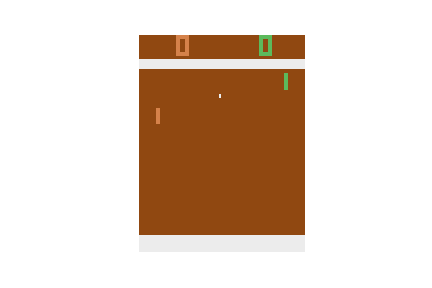
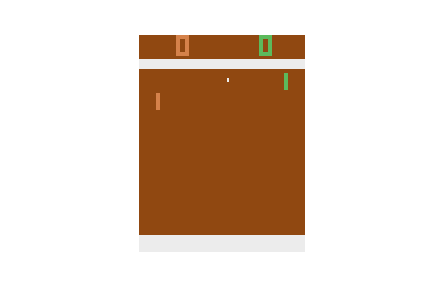
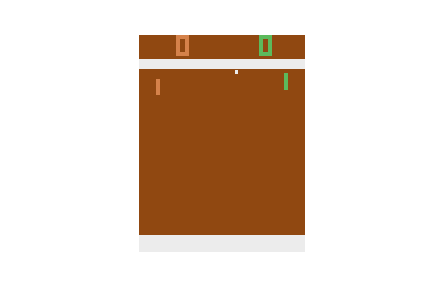
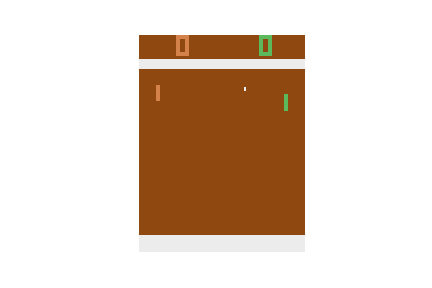
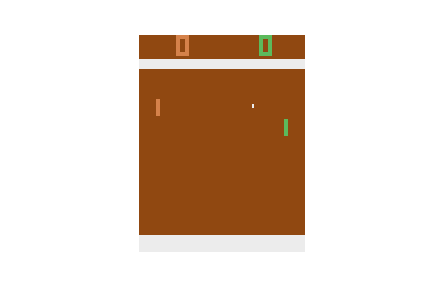
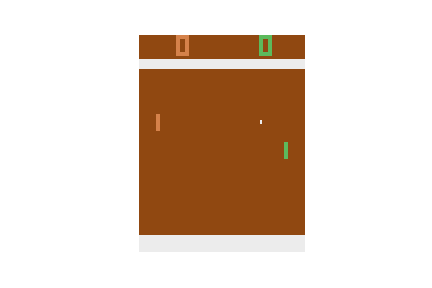
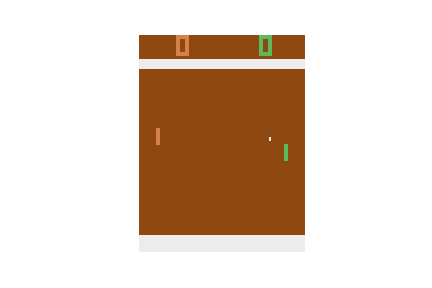
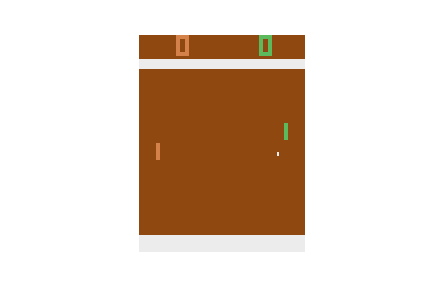
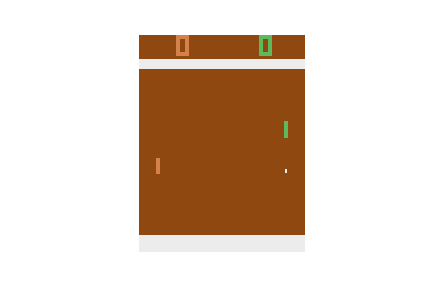
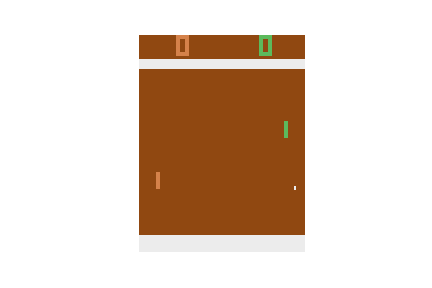
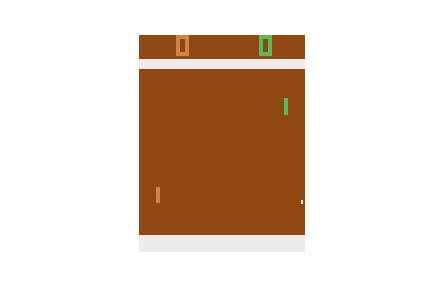
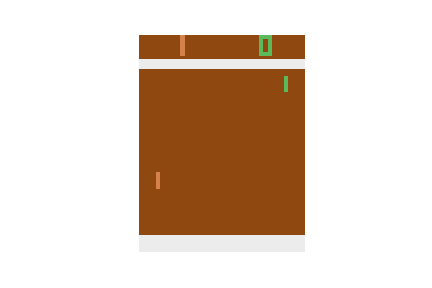
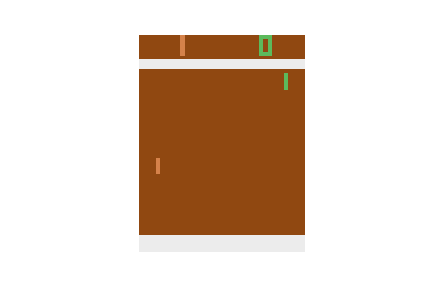
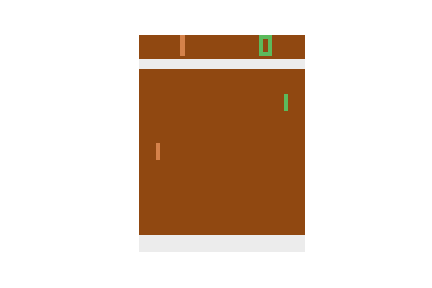
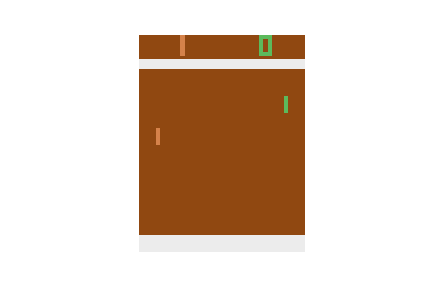
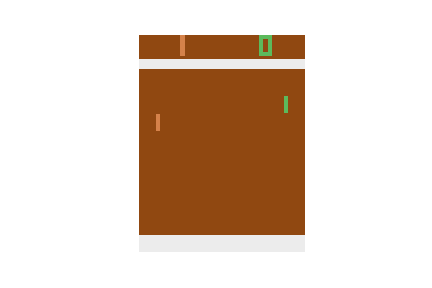
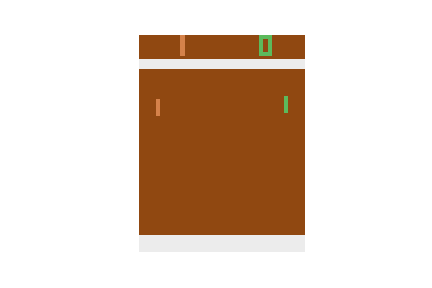
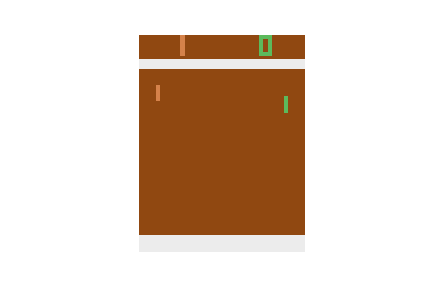
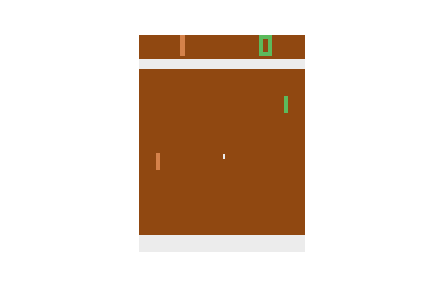
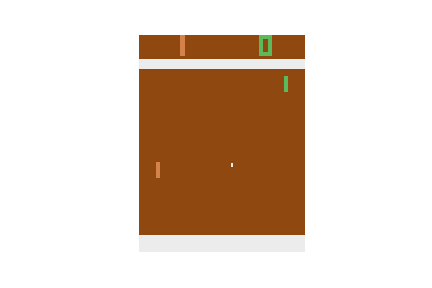
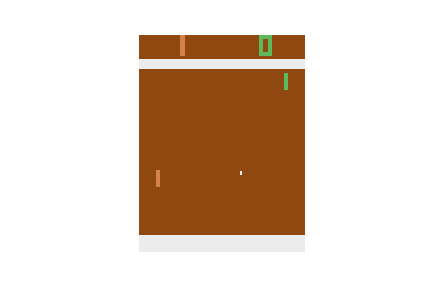
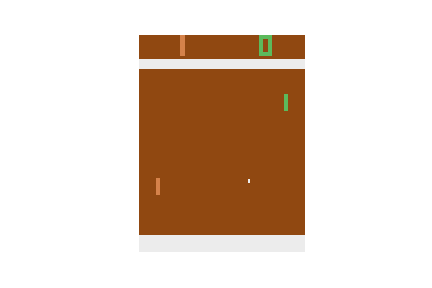
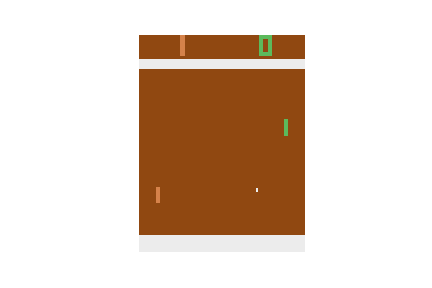
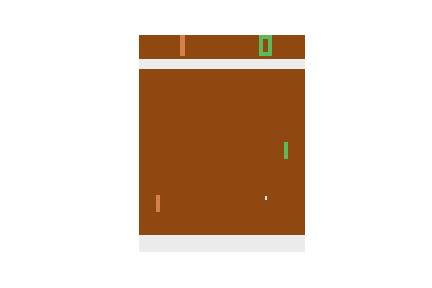
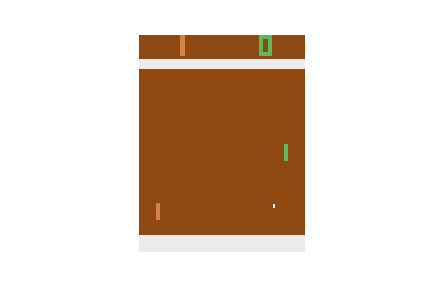
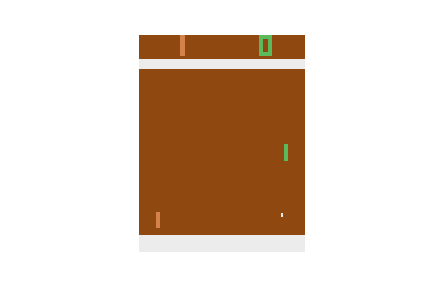
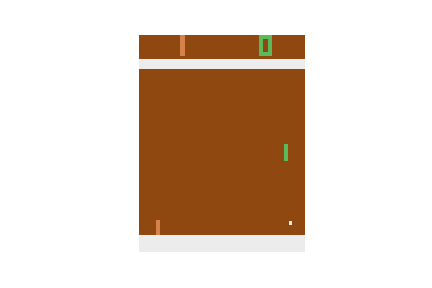
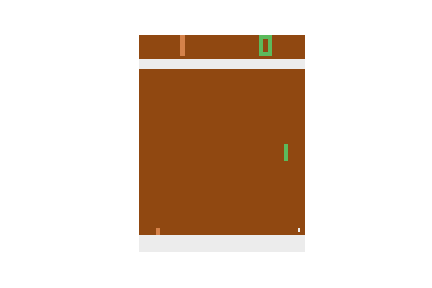
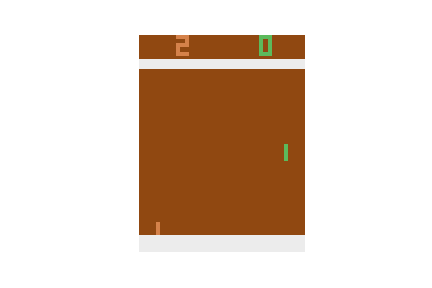
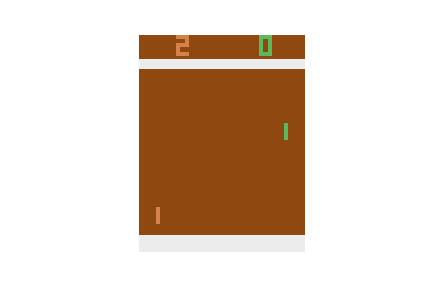
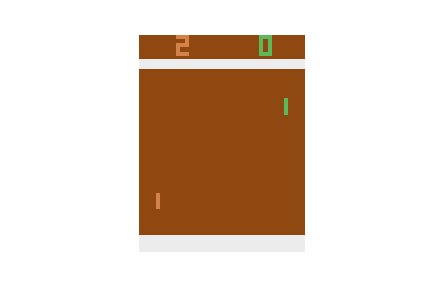
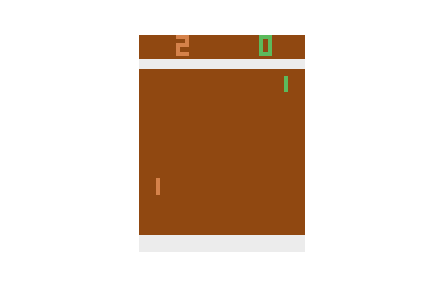
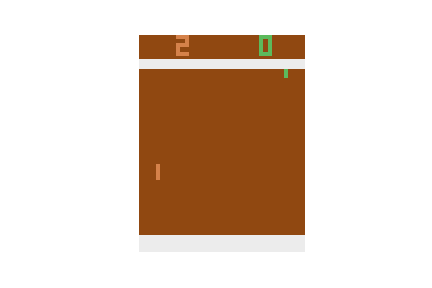
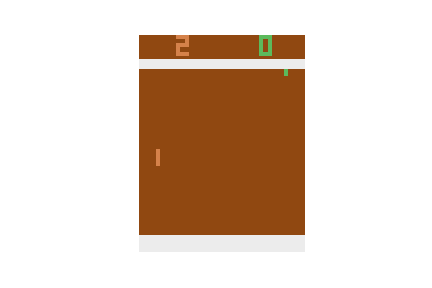
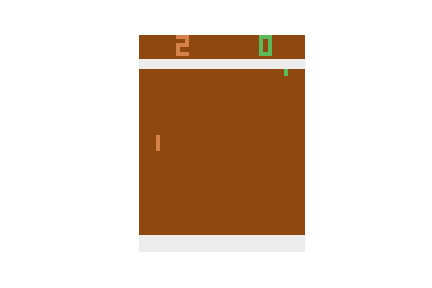
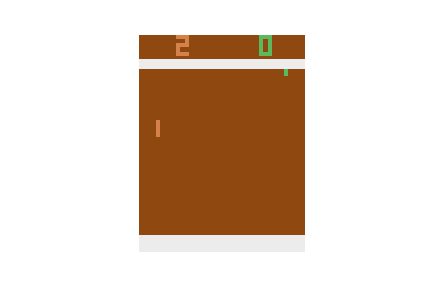
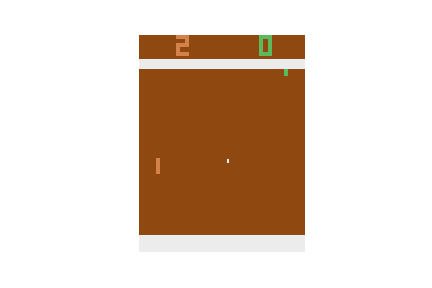
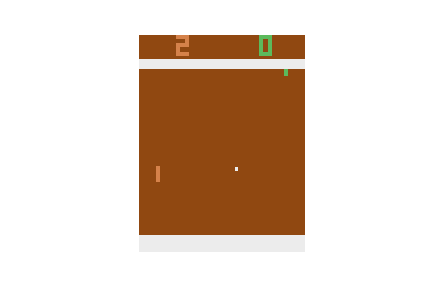
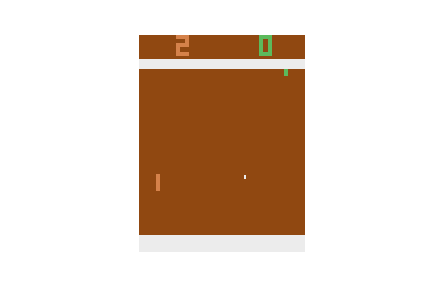
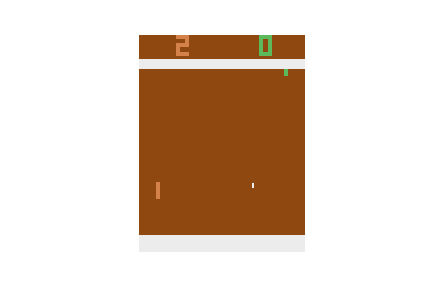
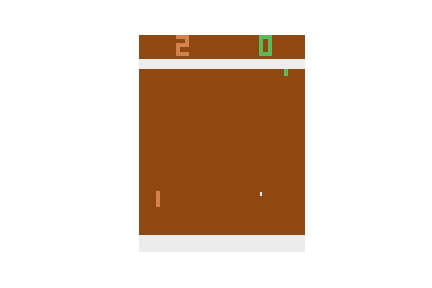
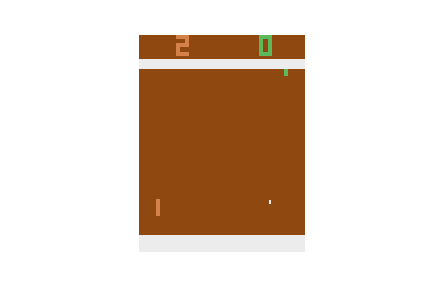
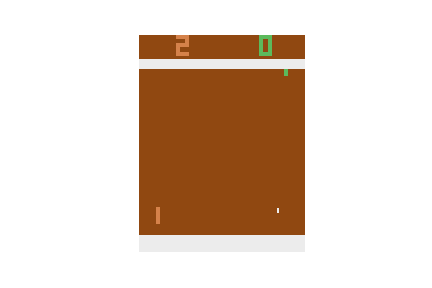
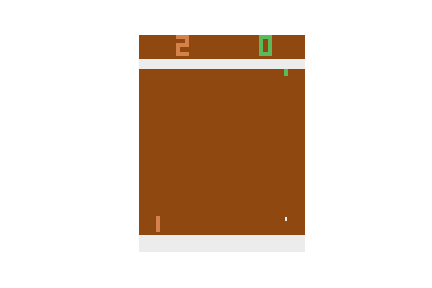
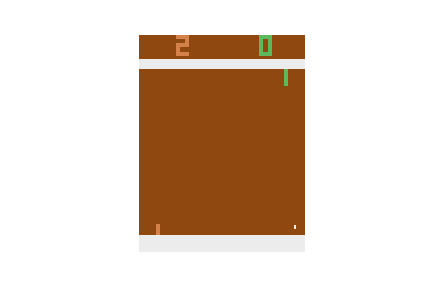
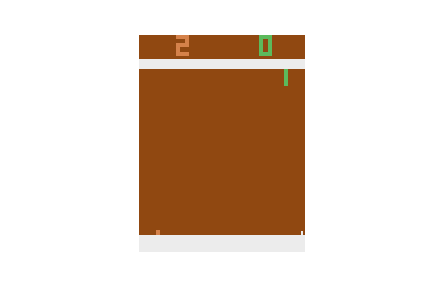
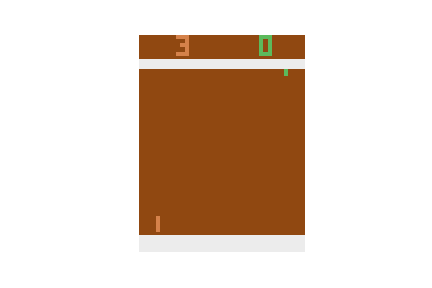
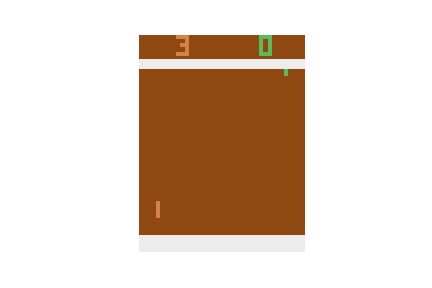
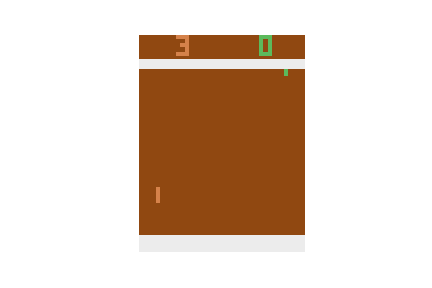
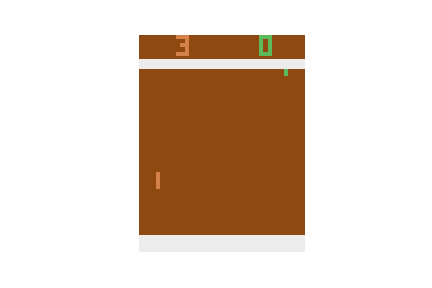
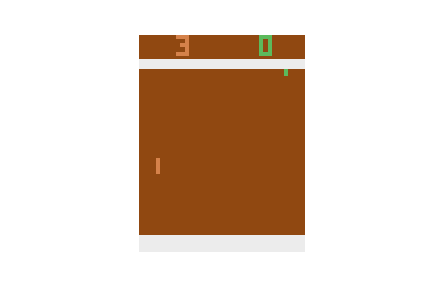
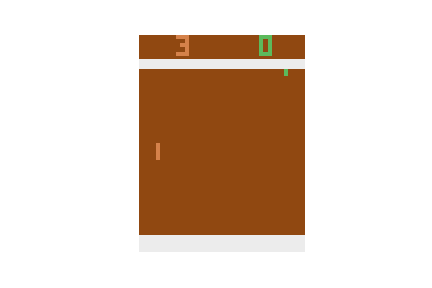
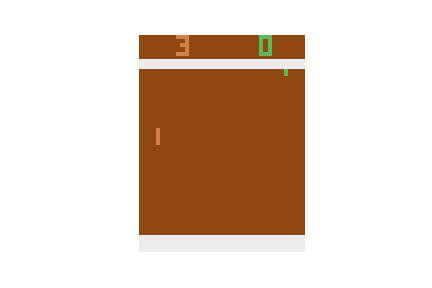
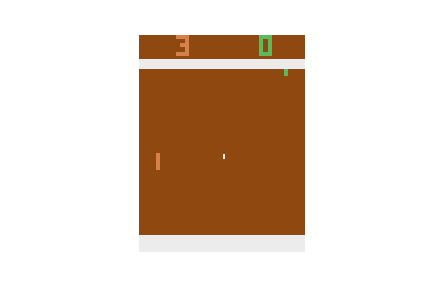
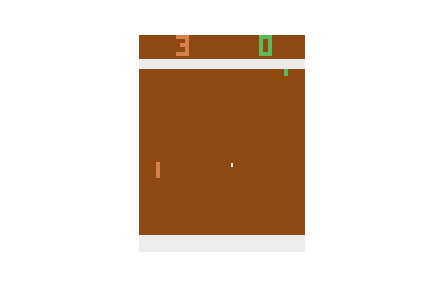
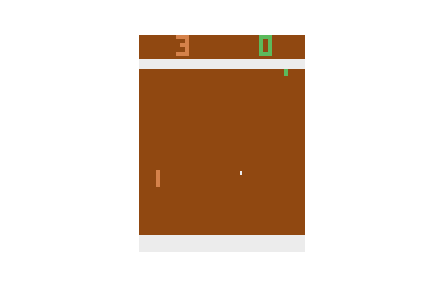
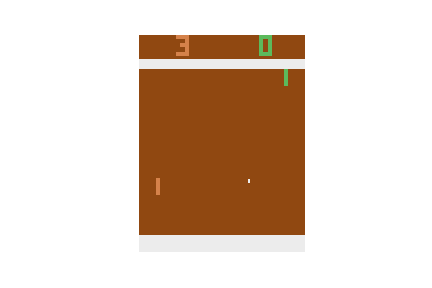
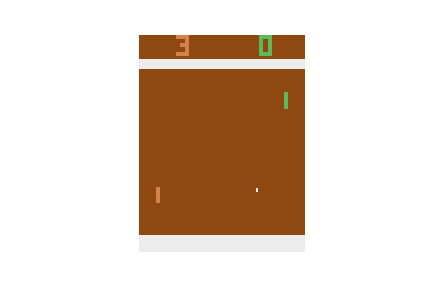
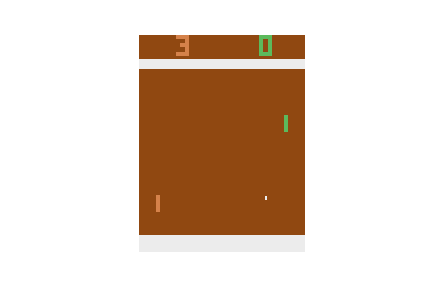
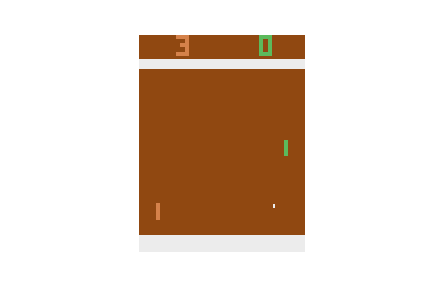
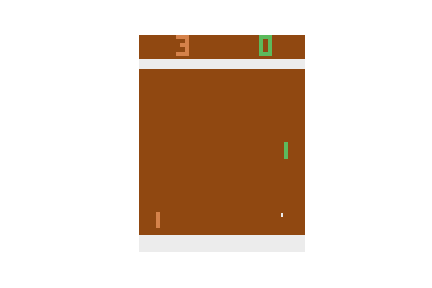
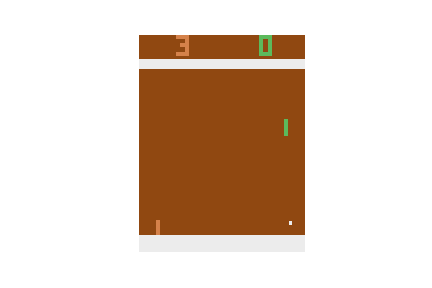
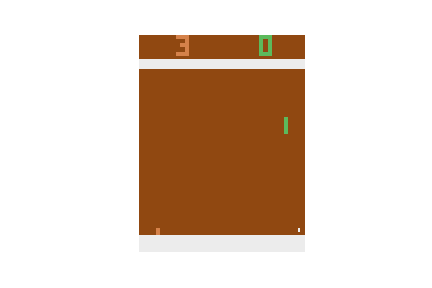
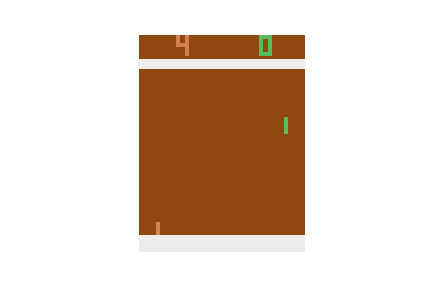
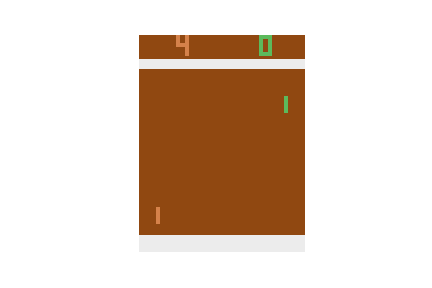
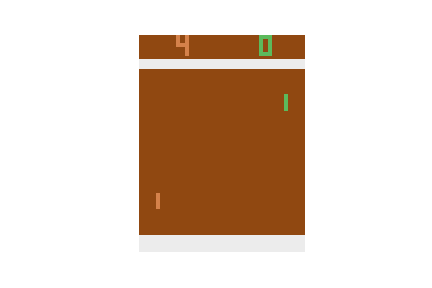
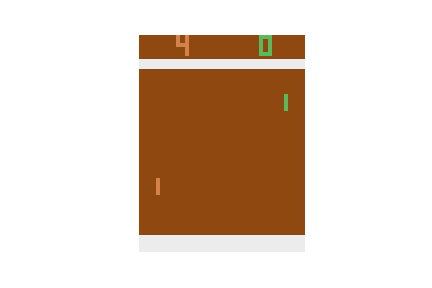
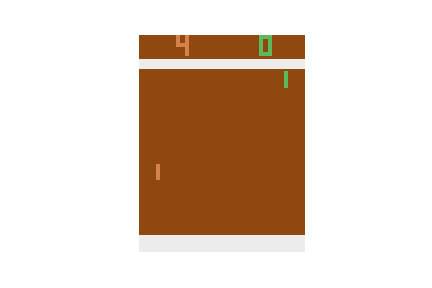
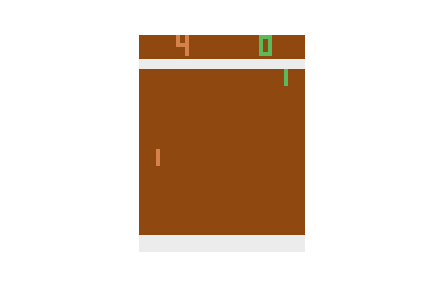
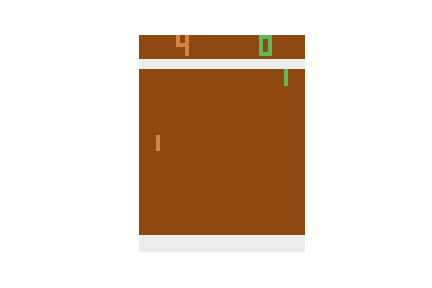
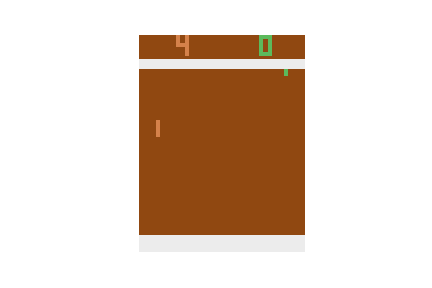
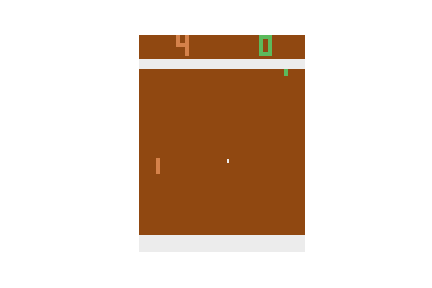
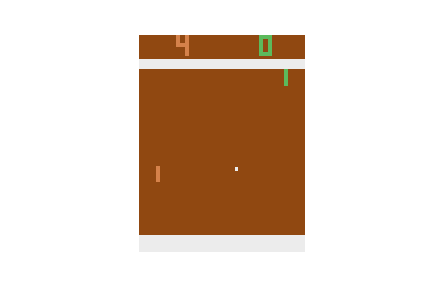
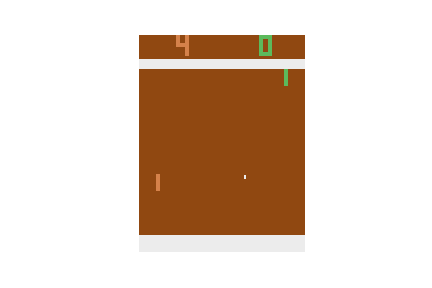
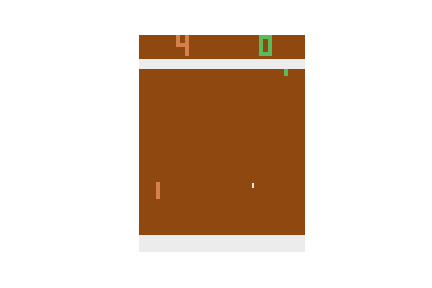
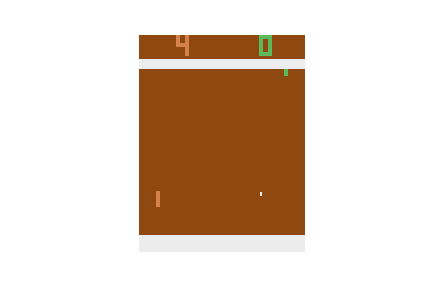
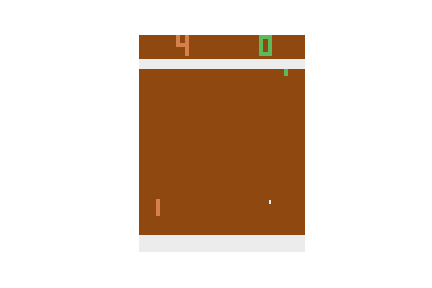
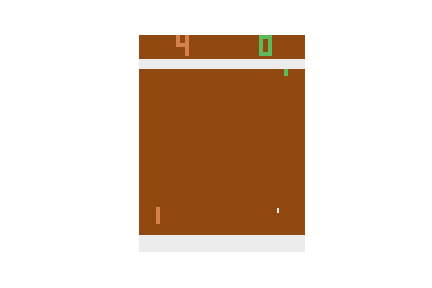
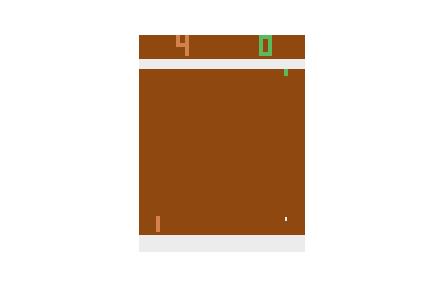
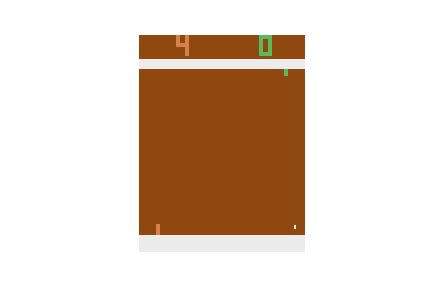
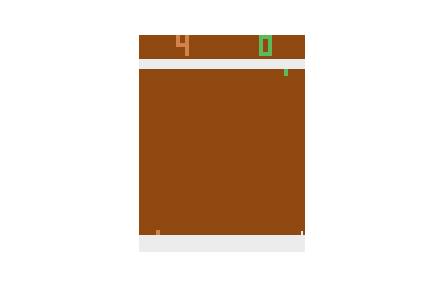
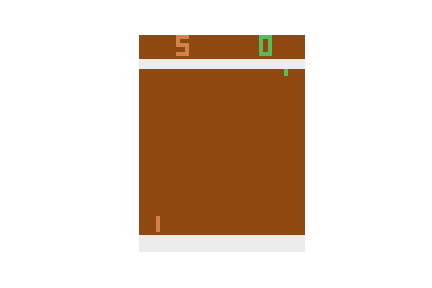
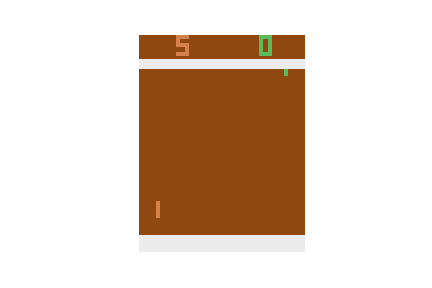
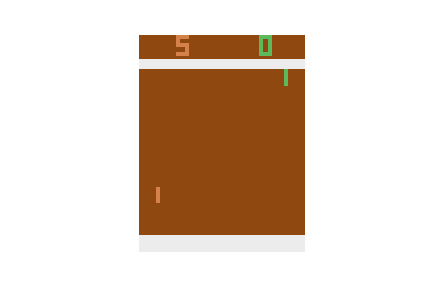
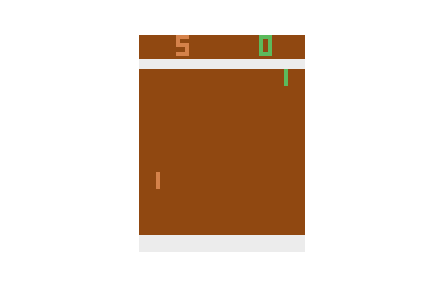
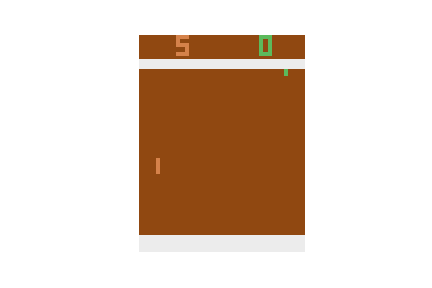
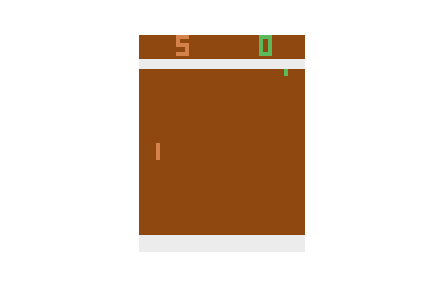
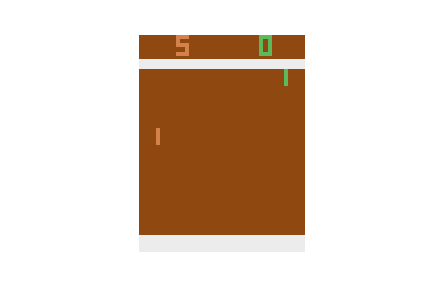
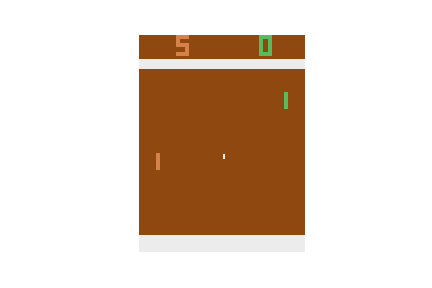
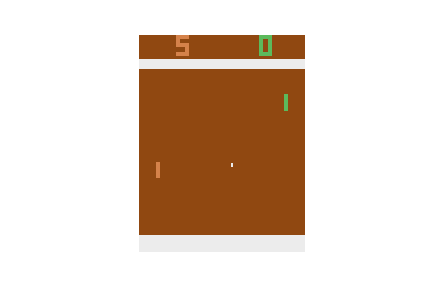
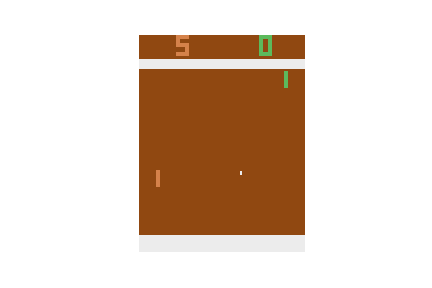
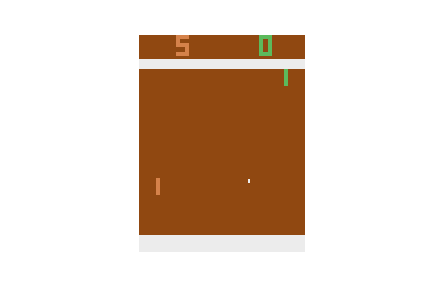
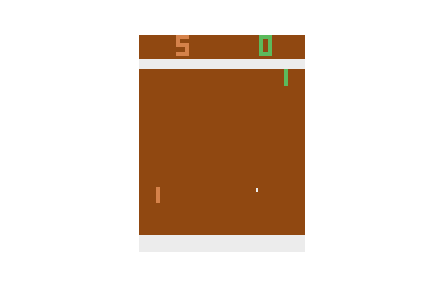
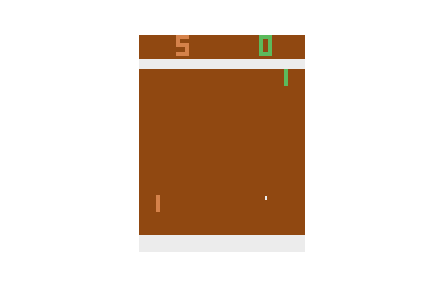
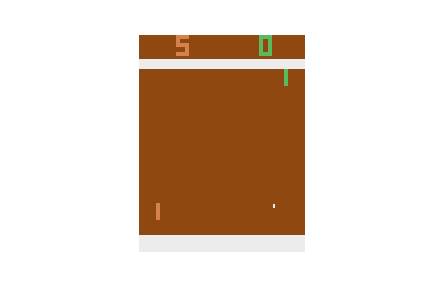
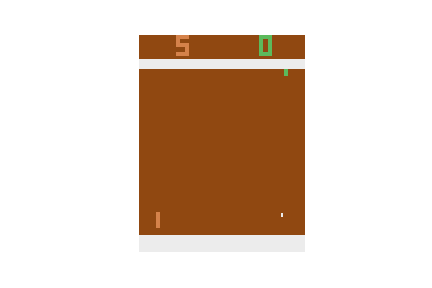
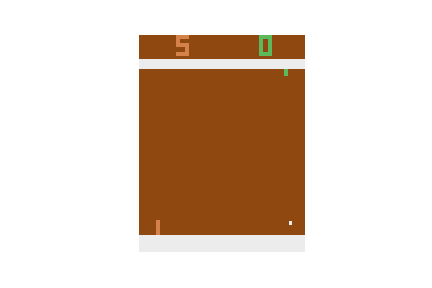
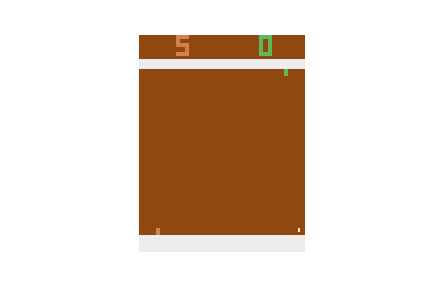
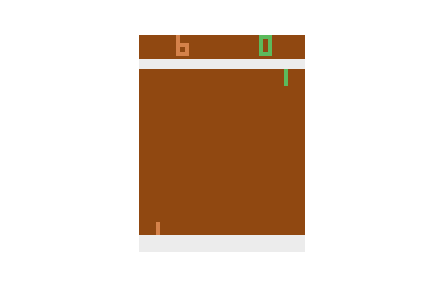
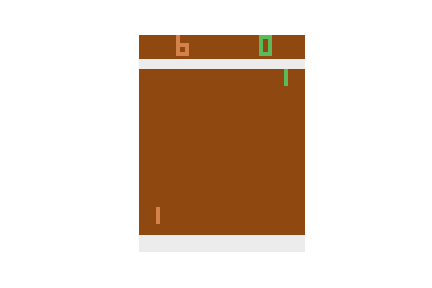
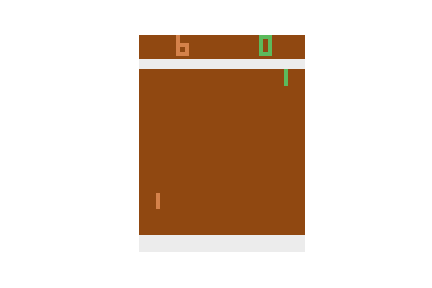
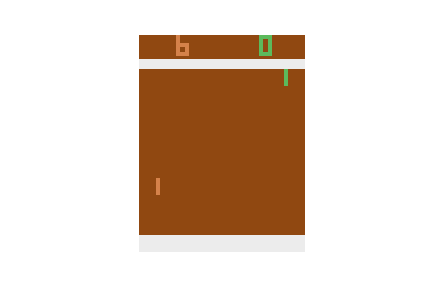
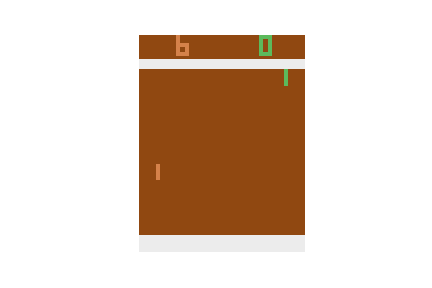
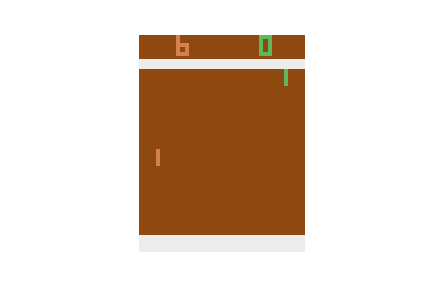
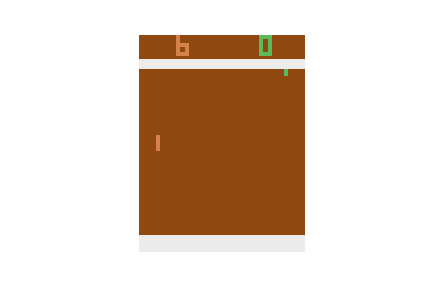
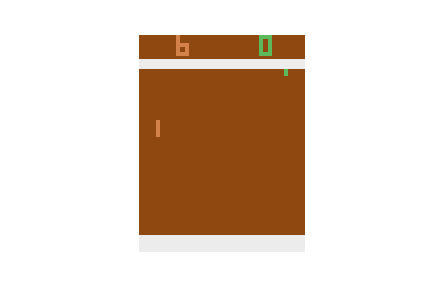
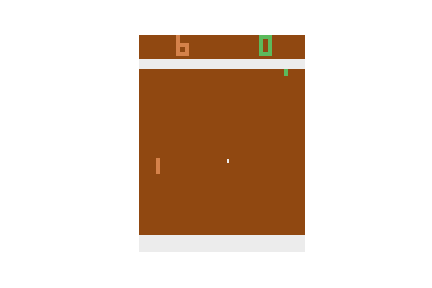
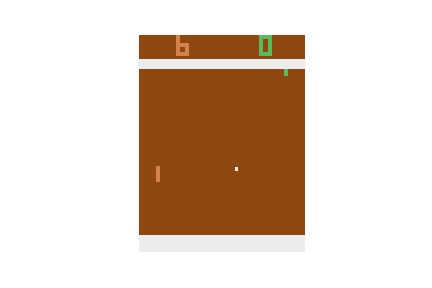
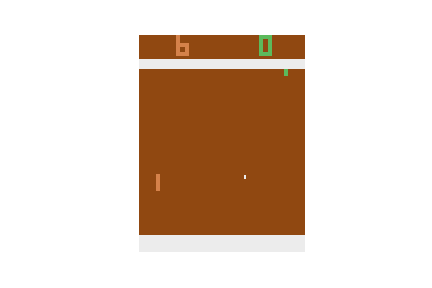
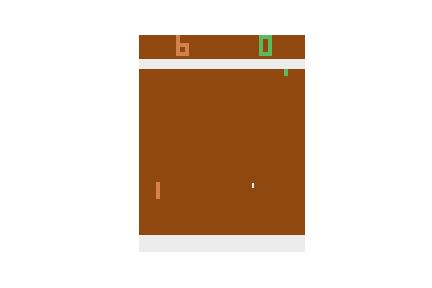
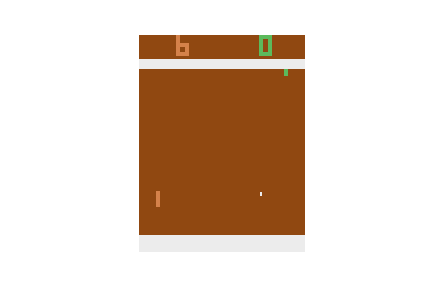
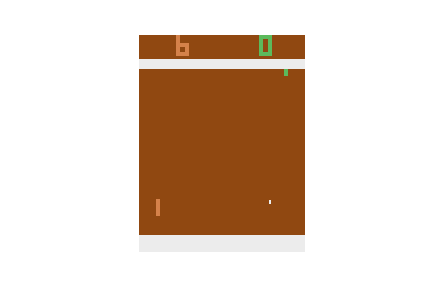
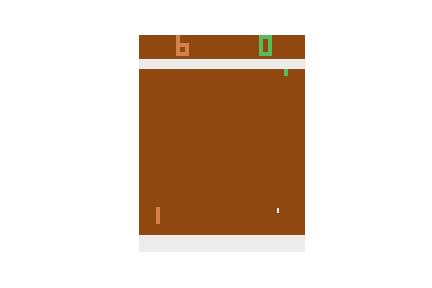
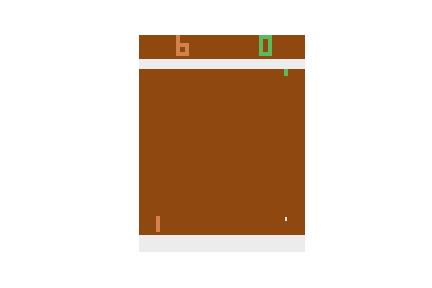
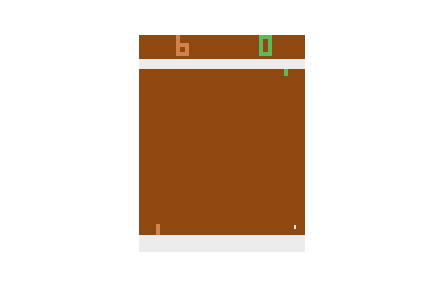
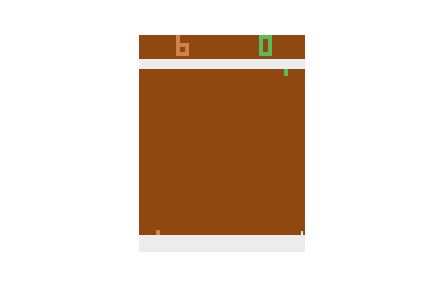
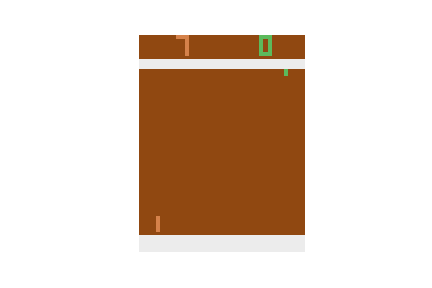
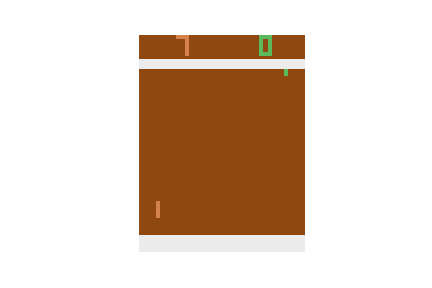
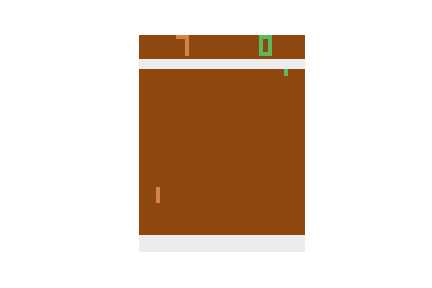
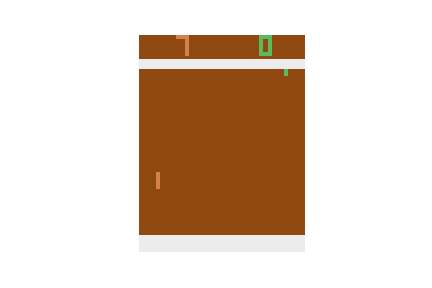
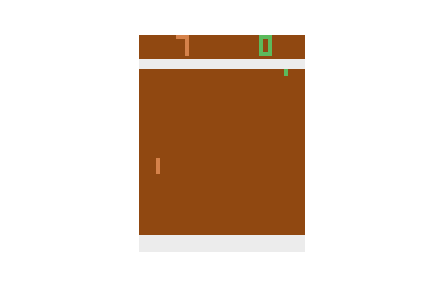
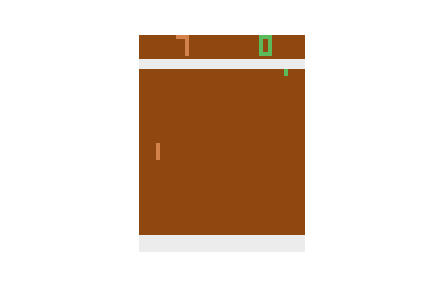
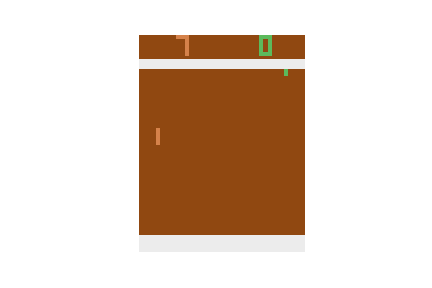
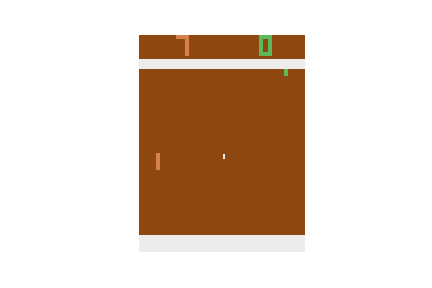
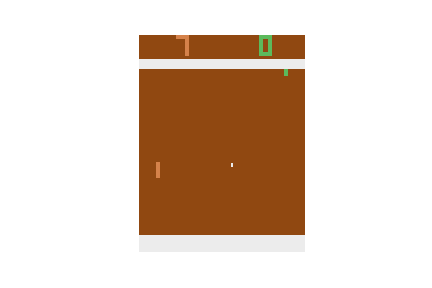
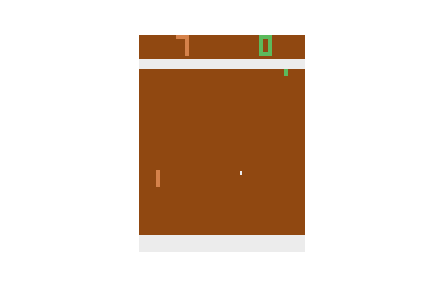
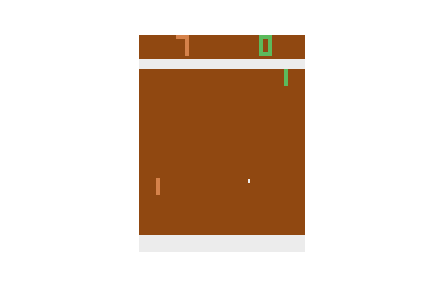
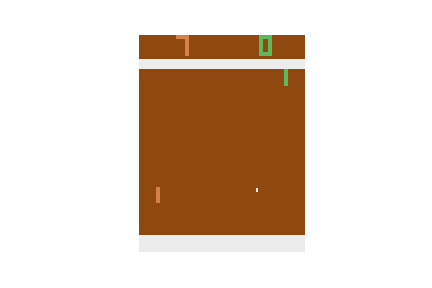
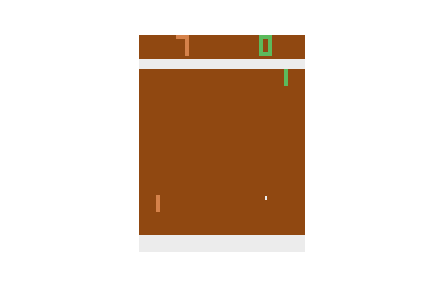
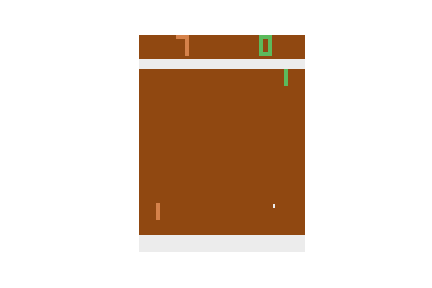
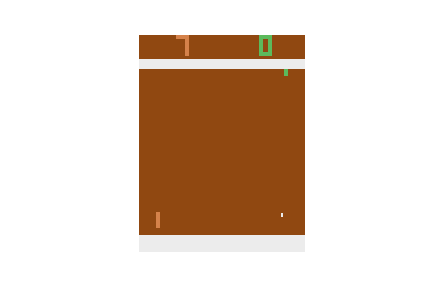
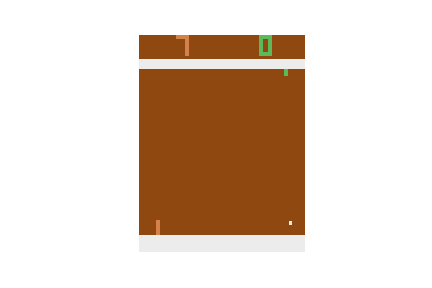
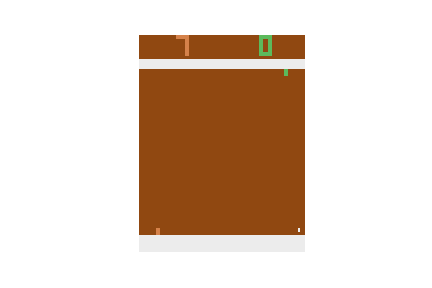
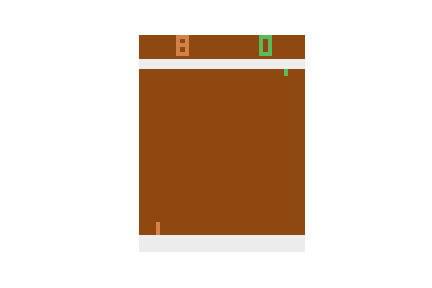
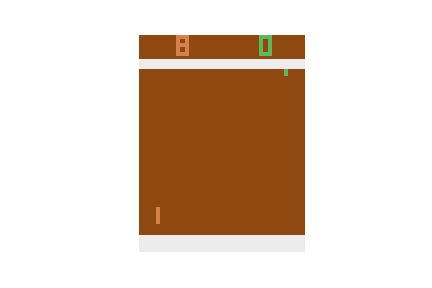
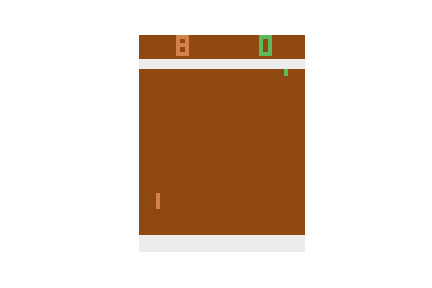
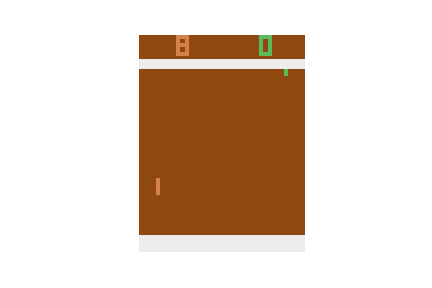
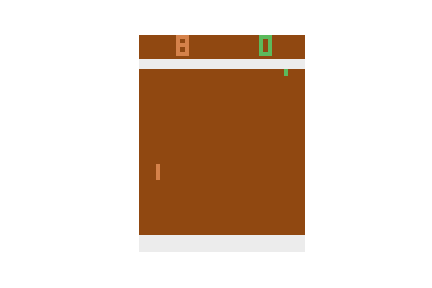
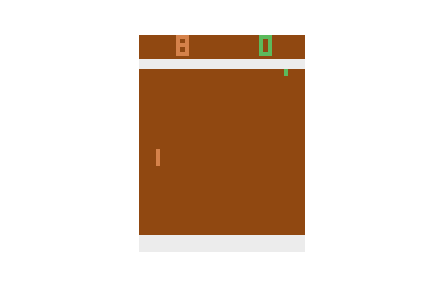
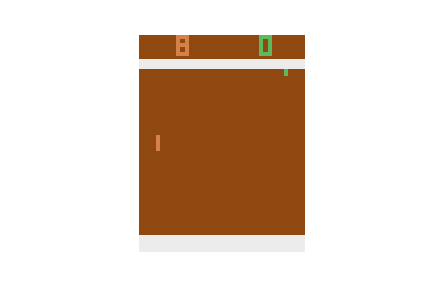
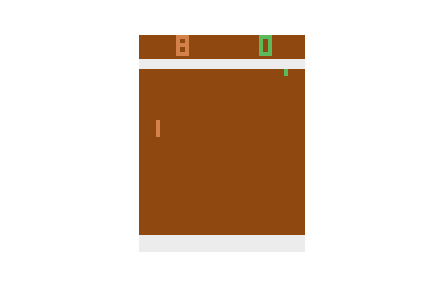
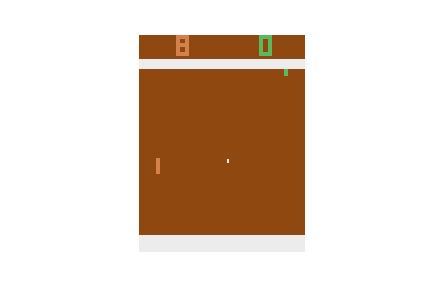
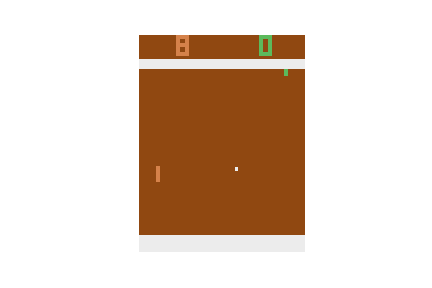
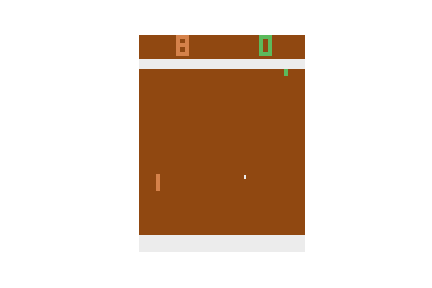
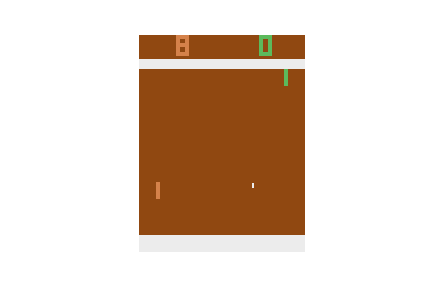
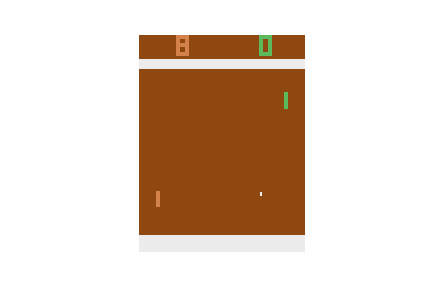
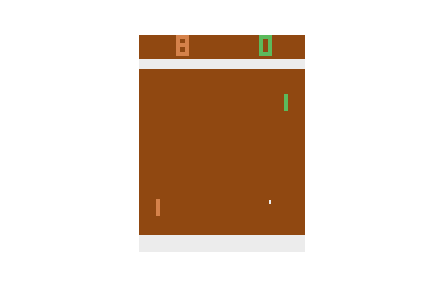
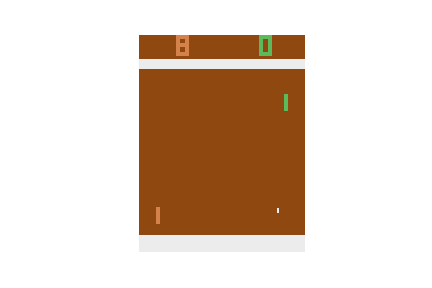
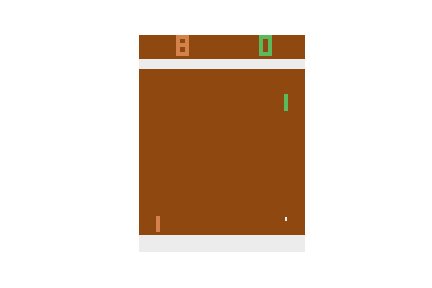
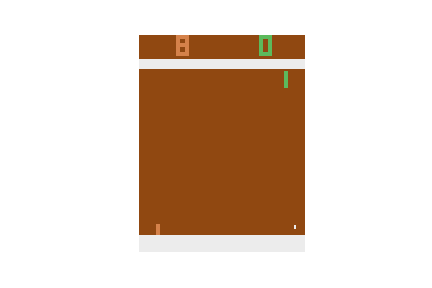
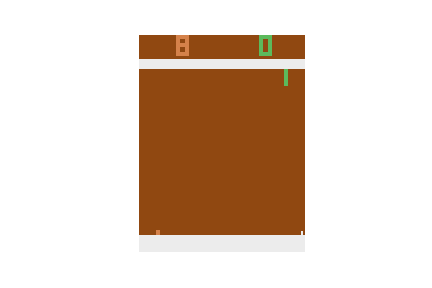
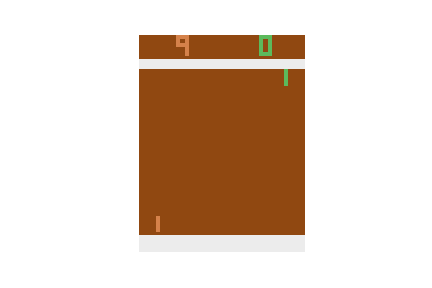
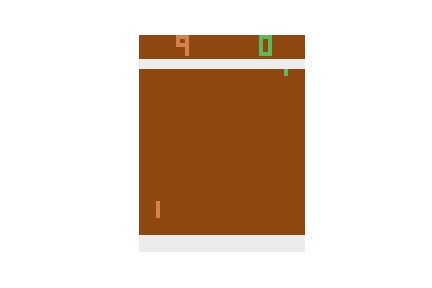
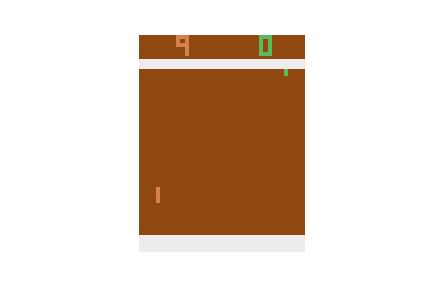
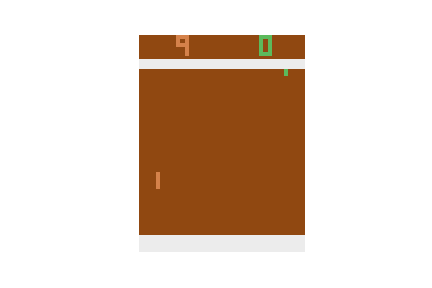
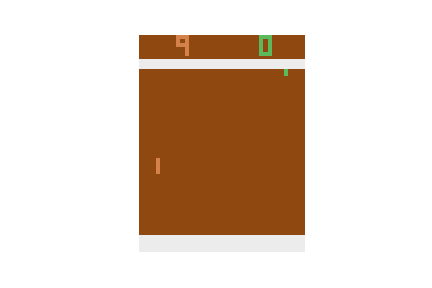
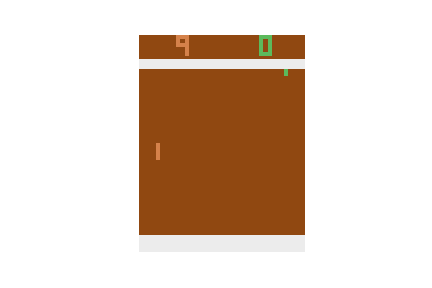
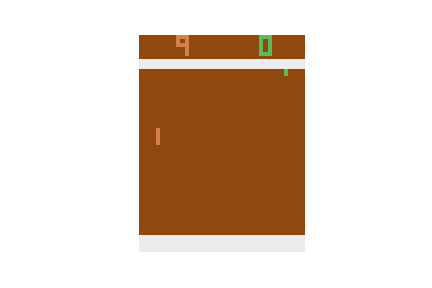
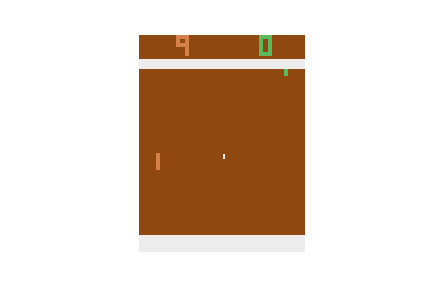
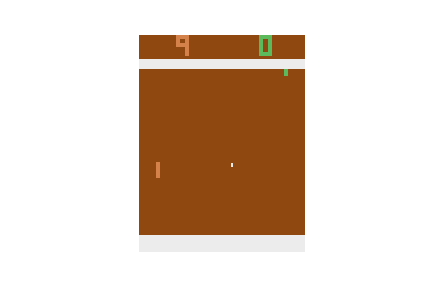
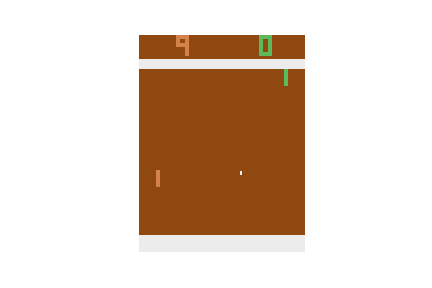
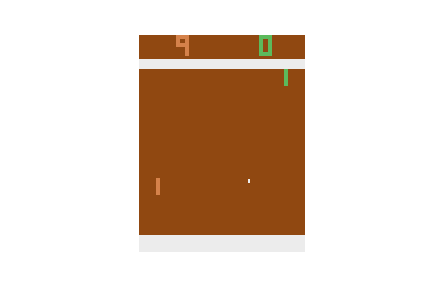
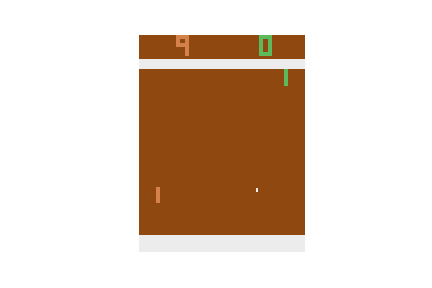
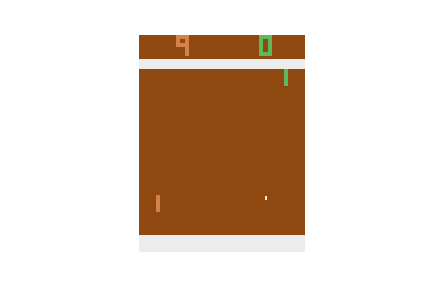
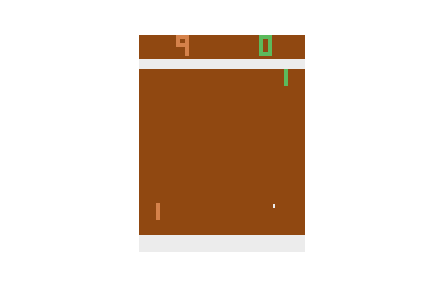
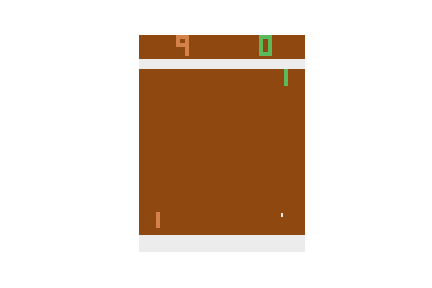
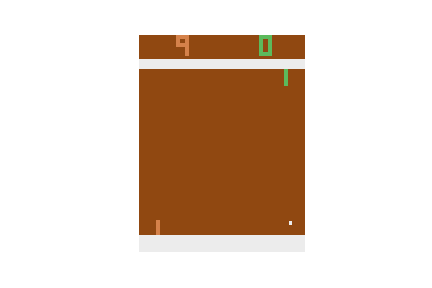
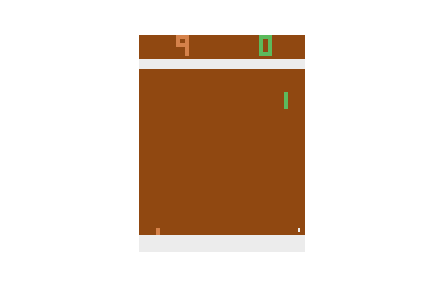
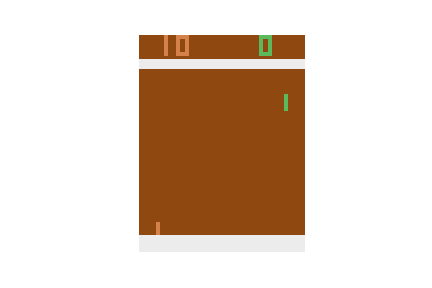
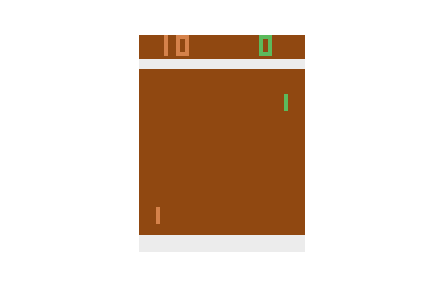
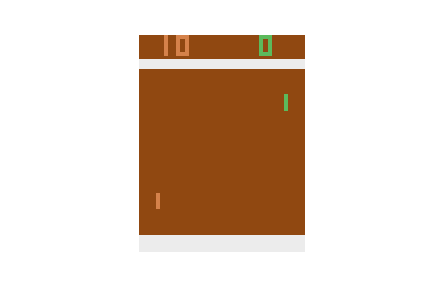
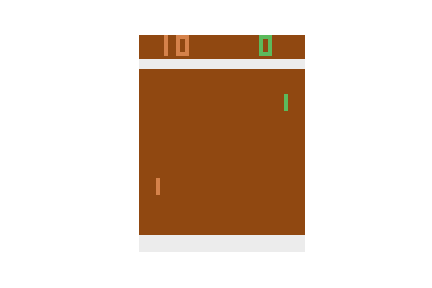
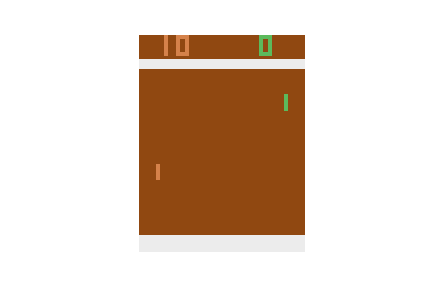
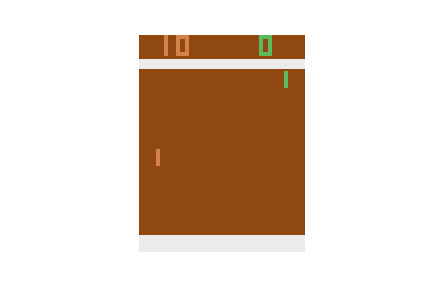
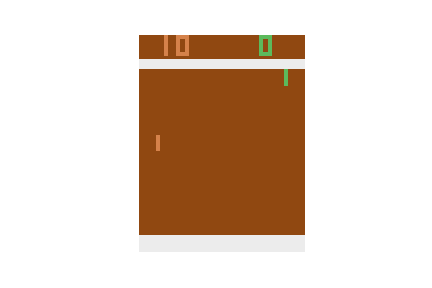
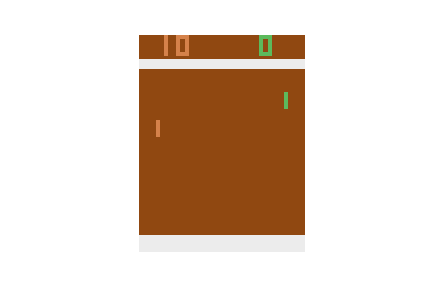
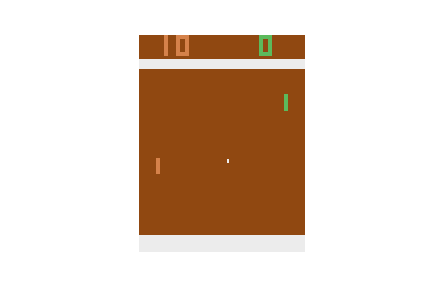
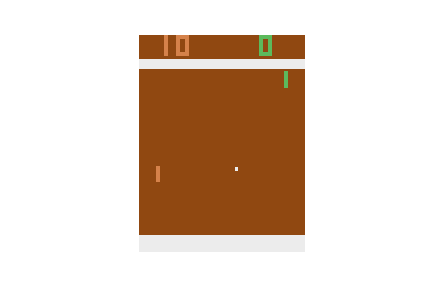
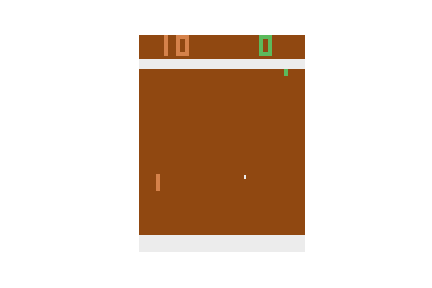
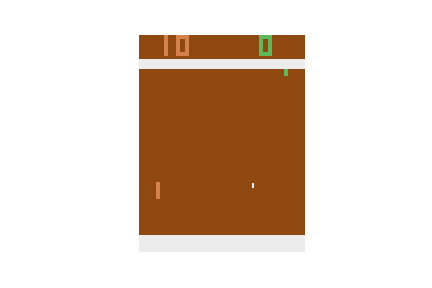
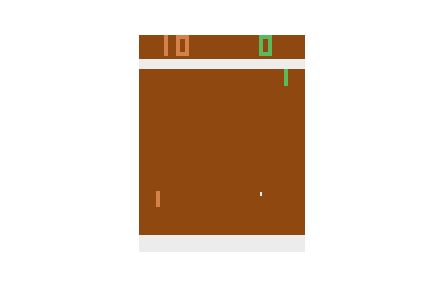
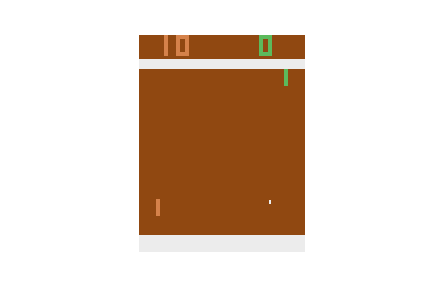
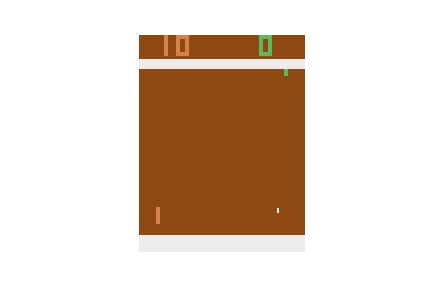
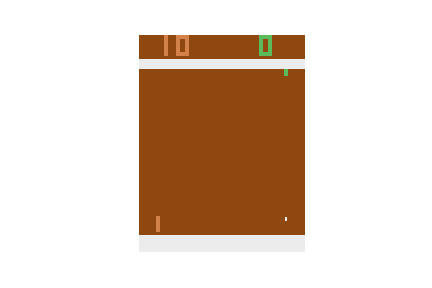

In [6]:
pong_utils.play(env, policy, time=200) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(what I call scalar function is the same as policy_loss up to a negative sign)

### PPO
Later on, you'll implement the PPO algorithm as well, and the scalar function is given by
$\frac{1}{T}\sum^T_t \min\left\{R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)},R_{t}^{\rm future}{\rm clip}_{\epsilon}\!\left(\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}\right)\right\}$

the ${\rm clip}_\epsilon$ function is implemented in pytorch as ```torch.clamp(ratio, 1-epsilon, 1+epsilon)```

In [7]:
def clipped_surrogate(policy, old_probs, states, actions, rewards,
                      discount = 0.995, epsilon=0.1, beta=0.01):

    ########
    ## 
    ## WRITE YOUR OWN CODE HERE
    ## #from the pong_utils
    discount = discount**np.arange(len(rewards))
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # FROM pong_util convert rewards to future rewards
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
    std = np.std(rewards_future, axis=1) + 1.0e-10
    
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
    
    # FROM pong_util convert everything into pytorch tensors and move to gpu if available
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    

    # FROM pong_util convert states to policy (or probability)
    new_probs = pong_utils.states_to_prob(policy, states)
    new_probs = torch.where(actions == pong_utils.RIGHT, new_probs, 1.0-new_probs)
    
    
    #FROM pong_util ratio for clipping
    ratio = new_probs/old_probs

    #FROM pong_util clipped function
    clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
    clipped_surrogate = torch.min(ratio*rewards, clip*rewards)
    
    ########

    # include a regularization term
    # this steers new_policy towards 0.5
    # prevents policy to become exactly 0 or 1 helps exploration
    # add in 1.e-10 to avoid log(0) which gives nan
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
        (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))

    return torch.mean(beta*entropy)


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [12]:
# #progressbar is for python2.7.Use tqdm instead for python3.6

# ######################################
# import progressbar as pb

# #initialize widgets
# widgets = ['Time for loop of 1 000 000 iterations: ', pb.Percentage(), ' ',  
#             pb.Bar(marker=pb.RotatingMarker()), ' ', pb.ETA()]

# #initialize timer
# timer = pb.ProgressBar(widgets=widgets, maxval=1000000).start()

# #for loop example
# for i in range(0,5000000):  
#     #update
#     timer.update(i)
# #finish
# timer.finish()

ModuleNotFoundError: No module named 'progressbar'

In [17]:
# ######################################
# import tqdm 
# for iii in tqdm.tqdm(range(0, 10000000), 'Time for loop of 1 000 000 iterations: ', 100000):
#     pass

Time for loop of 1 000 000 iterations: : 10000000it [00:04, 2037004.16it/s]      


In [8]:
# from parallelEnv import parallelEnv
# import numpy as np
# #import tqdm 

# # keep track of how long training takes
# # WARNING: running through all 800 episodes will take 30-45 minutes

# # training loop max iterations
# episode = 5 #00

# # widget bar to display progress
# #!pip install progressbar
# import progressbar as pb
 
# widget = ['training loop: ', pb.Percentage(), ' ',   pb.Bar(), ' ', pb.ETA() ]
# timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

# discount_rate = .99
# epsilon = 0.1
# beta = .01
# tmax = 320
# SGD_epoch = 4

# # keep track of progress
# mean_rewards = []

# for e in tqdm.tqdm(range(episode), 'Time for loop of episode iterations: ', 1):

#     # collect trajectories
#     old_probs, states, actions, rewards = \
#         pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
#     total_rewards = np.sum(rewards, axis=0)


#     # gradient ascent step
#     for _ in range(SGD_epoch):
        
#         # uncomment to utilize your own clipped function!
#         # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

#         L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
#                                           epsilon=epsilon, beta=beta)
#         optimizer.zero_grad()
#         L.backward()
#         optimizer.step()
#         del L
    
#     # the clipping parameter reduces as time goes on
#     epsilon*=.999
    
#     # the regulation term also reduces
#     # this reduces exploration in later runs
#     beta*=.995
    
#     # get the average reward of the parallel environments
#     mean_rewards.append(np.mean(total_rewards))
    
#     # display some progress every 20 iterations
#     if (e+1)%20 ==0 :
#         print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
#         print(total_rewards)
        
#     # update progress widget bar
#     #timer.update(e+1)
#     pass
    
# #timer.finish()

training loop: N/A% |                                          | ETA:  --:--:--

NameError: name 'tqdm' is not defined

In [ ]:
from parallelEnv import parallelEnv
import numpy as np
# keep track of how long training takes
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 500

# widget bar to display progress
#!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()


envs = parallelEnv('PongDeterministic-v4', n=8, seed=1234)

discount_rate = .99
epsilon = 0.1
beta = .01
tmax = 320
SGD_epoch = 4

# keep track of progress
mean_rewards = []

for e in range(episode):

    # collect trajectories
    old_probs, states, actions, rewards = \
        pong_utils.collect_trajectories(envs, policy, tmax=tmax)
        
    total_rewards = np.sum(rewards, axis=0)


    # gradient ascent step
    for _ in range(SGD_epoch):
        
        # uncomment to utilize your own clipped function!
        # L = -clipped_surrogate(policy, old_probs, states, actions, rewards, epsilon=epsilon, beta=beta)

        L = -pong_utils.clipped_surrogate(policy, old_probs, states, actions, rewards,
                                          epsilon=epsilon, beta=beta)
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        del L
    
    # the clipping parameter reduces as time goes on
    epsilon*=.999
    
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
        print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()

/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages/pip/_internal/req/req_install.py:391: UserWarning: Unbuilt egg for Unknown [unknown version] (/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages)
  self.satisfied_by = pkg_resources.get_distribution(str(no_marker))
Error checking for conflicts.
Traceback (most recent call last):
  File "/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2584, in version
    return self._version
  File "/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages/pip/_vendor/pkg_resources/__init__.py", line 2691, in __getattr__
    raise AttributeError(attr)
AttributeError: _version

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages/pip/_internal/commands/install.py", line 503, in _warn_about_conflicts
    package_set, _dep_info = check_install

training loop:   4% |#                                         | ETA:   5:14:03

Episode: 20, score: -14.000000
[ -9. -16. -12. -12. -16. -16. -15. -16.]


training loop:   8% |###                                       | ETA:   4:36:10

Episode: 40, score: -13.125000
[-14. -10. -16. -13. -14. -16. -11. -11.]


training loop:  12% |#####                                     | ETA:   4:01:25

Episode: 60, score: -14.500000
[-11. -15. -16. -15. -15. -16. -15. -13.]


training loop:  16% |######                                    | ETA:   3:36:04

Episode: 80, score: -14.625000
[-16. -14. -16.  -9. -16. -15. -15. -16.]


training loop:  20% |########                                  | ETA:   3:09:30

Episode: 100, score: -13.125000
[-11. -13. -16. -13. -10. -14. -14. -14.]


training loop:  24% |##########                                | ETA:   2:50:07

Episode: 120, score: -12.125000
[-15. -15. -10. -10. -13. -12.  -9. -13.]


training loop:  28% |###########                               | ETA:   2:34:08

Episode: 140, score: -12.375000
[ -9. -13. -14. -15. -12. -13. -13. -10.]


training loop:  32% |#############                             | ETA:   2:20:26

Episode: 160, score: -12.500000
[-16. -10. -12.  -7. -16. -14. -13. -12.]


training loop:  36% |###############                           | ETA:   2:08:30

Episode: 180, score: -11.250000
[-13. -10. -13. -11. -12.  -6.  -9. -16.]


training loop:  40% |################                          | ETA:   1:57:47

Episode: 200, score: -7.250000
[-12.  -9.  -9.  -4.  -7.  -2.  -5. -10.]


training loop:  44% |##################                        | ETA:   1:47:52

Episode: 220, score: -6.250000
[-6. -5. -3. -9. -7. -9. -5. -6.]


training loop:  48% |####################                      | ETA:   1:38:47

Episode: 240, score: -5.625000
[-7. -7. -6. -5. -7. -4. -5. -4.]


training loop:  52% |#####################                     | ETA:   1:29:52

Episode: 260, score: -3.125000
[-6. -3. -8. -2. -1. -4.  0. -1.]


training loop:  56% |#######################                   | ETA:   1:21:22

Episode: 280, score: -1.875000
[-1. -3. -1. -1. -1. -1. -6. -1.]


training loop:  60% |#########################                 | ETA:   1:13:09

Episode: 300, score: -2.000000
[-1. -1. -1. -1. -3. -1. -3. -5.]


training loop:  64% |##########################                | ETA:   1:05:12

Episode: 320, score: -2.875000
[-1. -5. -1. -1. -1. -2. -6. -6.]


training loop:  68% |############################              | ETA:   0:57:27

Episode: 340, score: -2.000000
[-2. -3. -4. -1. -1. -1. -1. -3.]


training loop:  72% |##############################            | ETA:   0:49:54

Episode: 360, score: -2.750000
[-11.  -2.  -1.  -1.  -1.  -4.  -1.  -1.]


training loop:  76% |###############################           | ETA:   0:42:28

Episode: 380, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


training loop:  80% |#################################         | ETA:   0:35:11

Episode: 400, score: -1.875000
[-5. -2. -1. -1. -2. -1. -2. -1.]


training loop:  84% |###################################       | ETA:   0:27:59

Episode: 420, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


training loop:  88% |####################################      | ETA:   0:20:53

Episode: 440, score: -1.125000
[-1. -3.  0. -1. -1. -1. -1. -1.]


training loop:  92% |######################################    | ETA:   0:13:55

Episode: 460, score: -1.000000
[-1. -1. -1. -1. -1. -1. -1. -1.]


training loop:  93% |#######################################   | ETA:   0:11:30


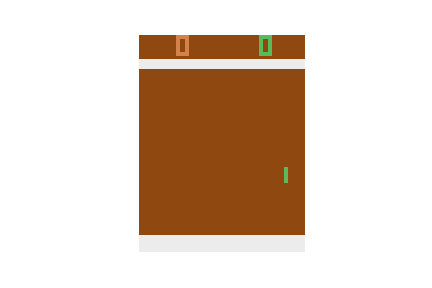
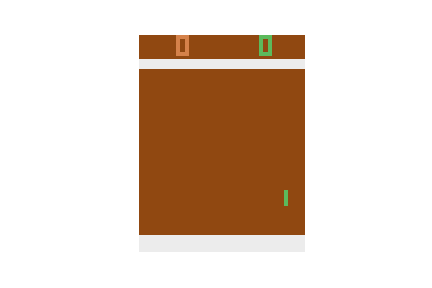
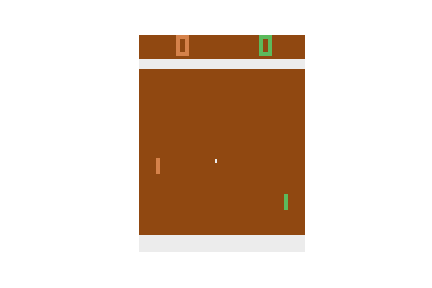
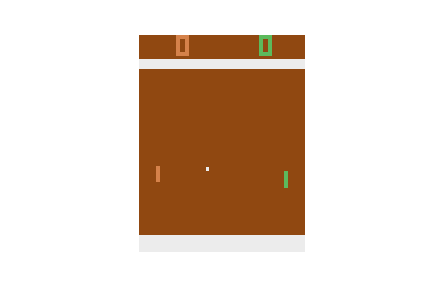
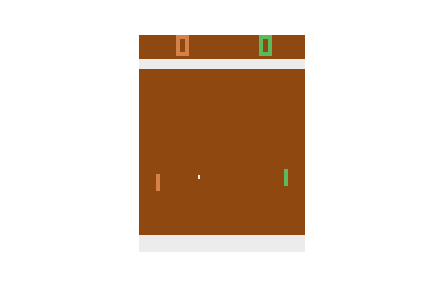
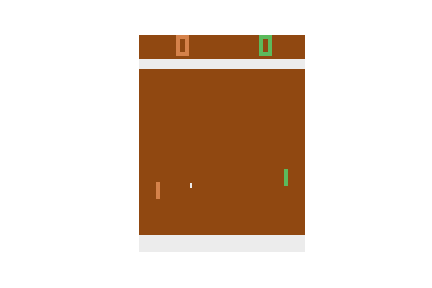
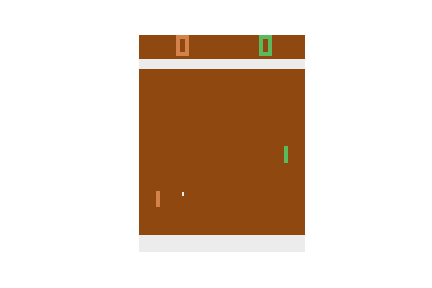
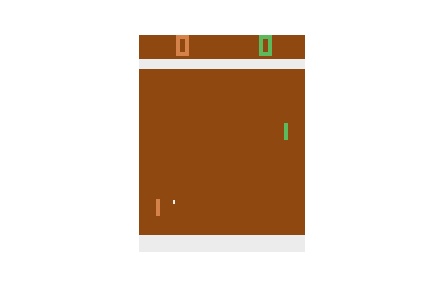
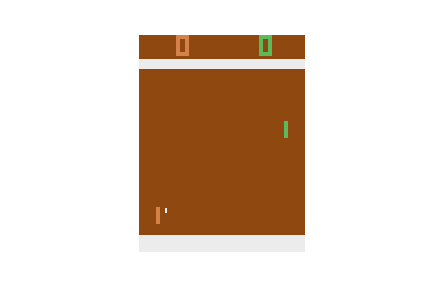
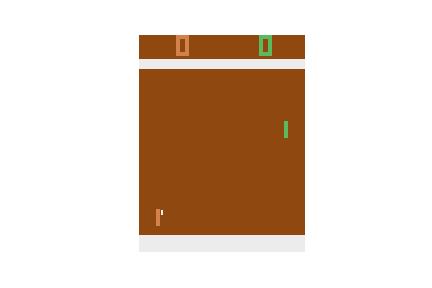
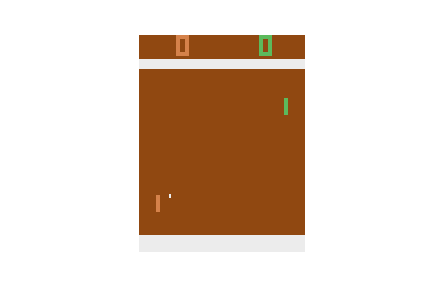
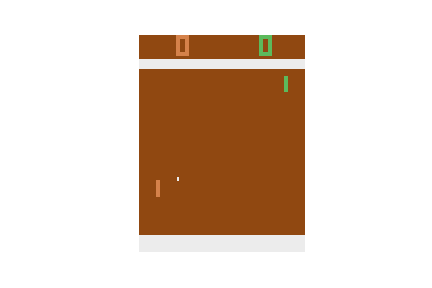
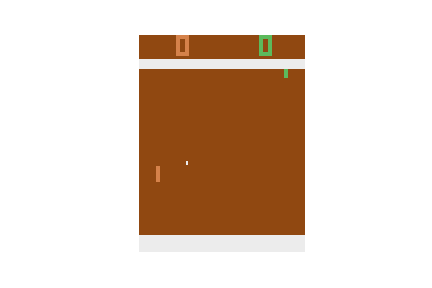
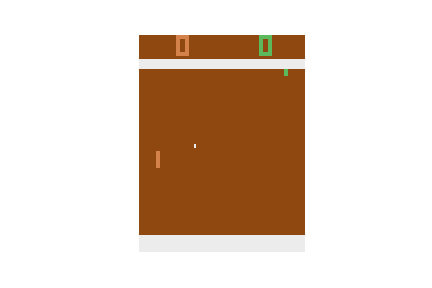
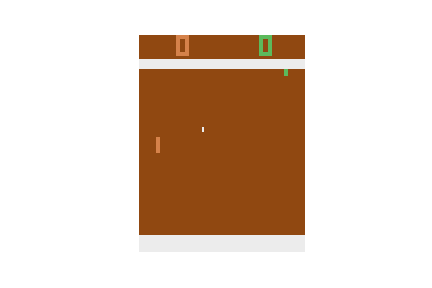
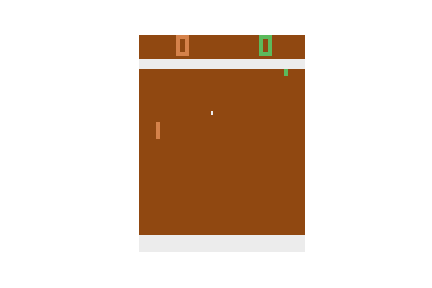
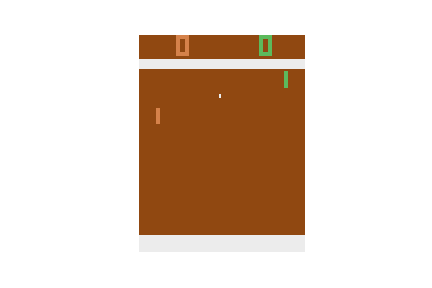
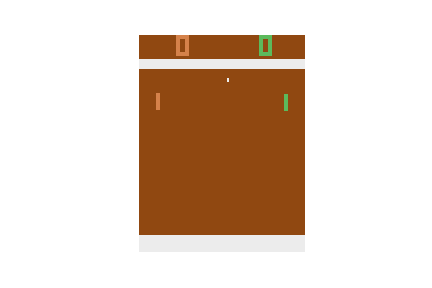
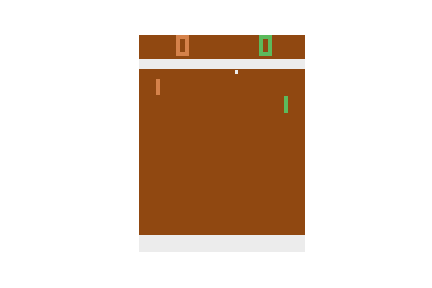
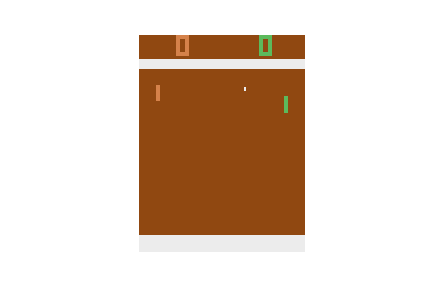
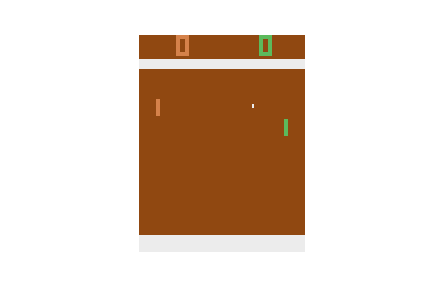
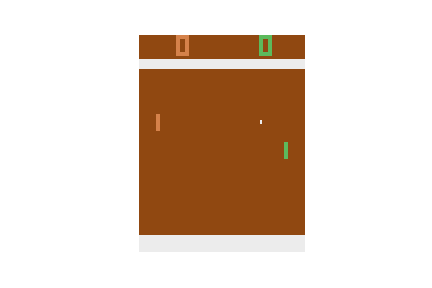
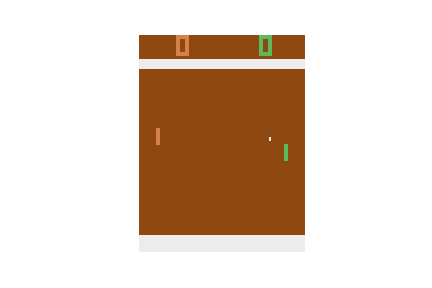
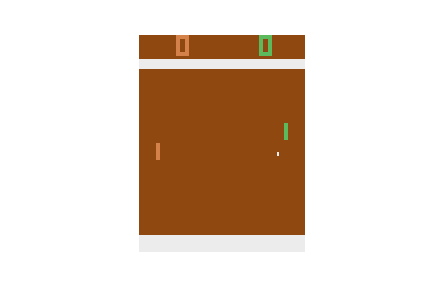
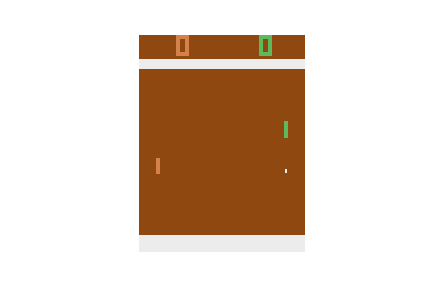
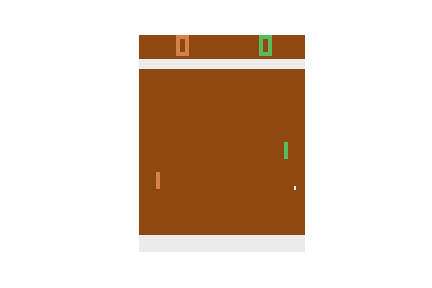
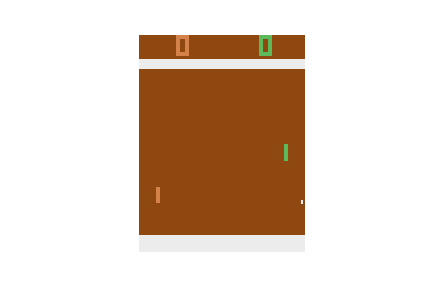
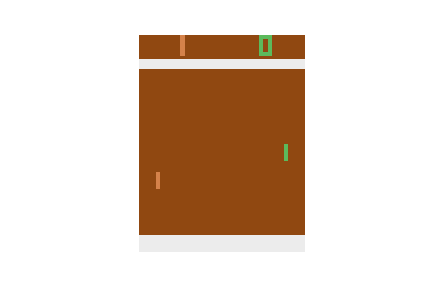
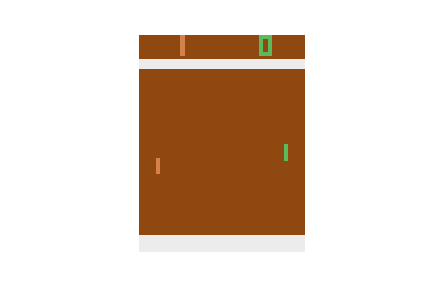
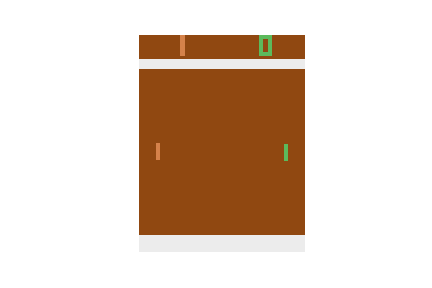
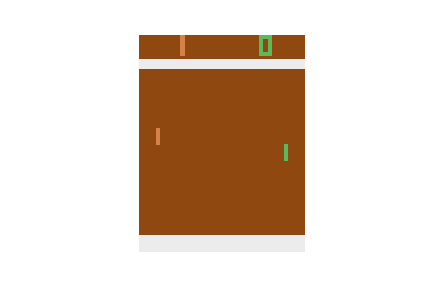
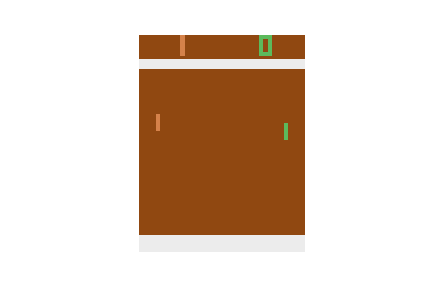
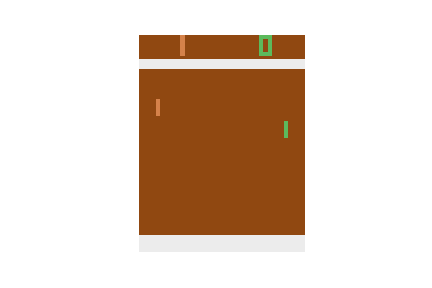
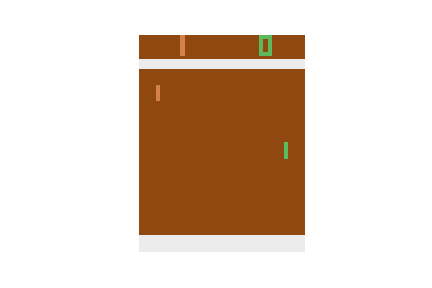
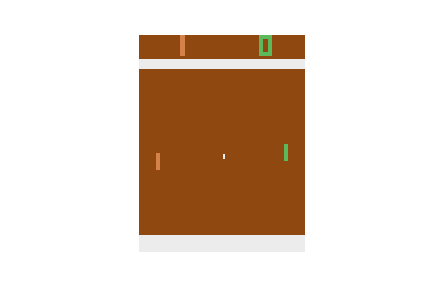
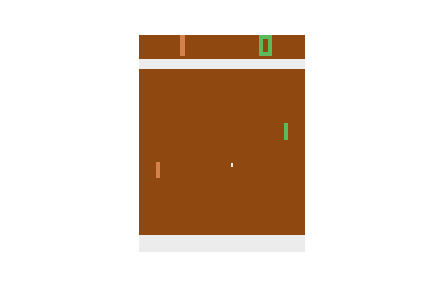
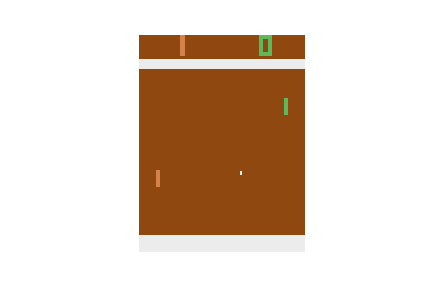
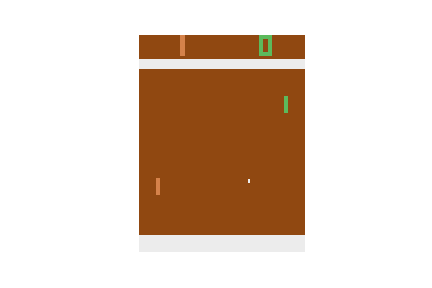
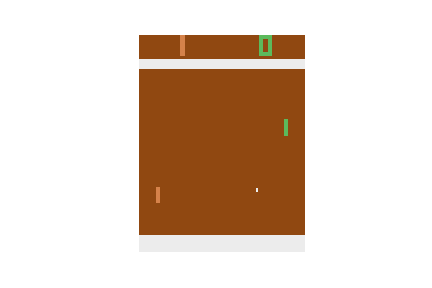
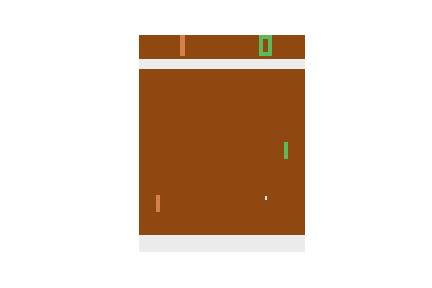
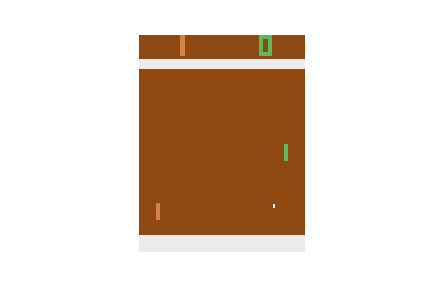
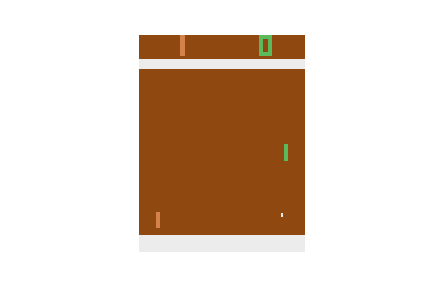
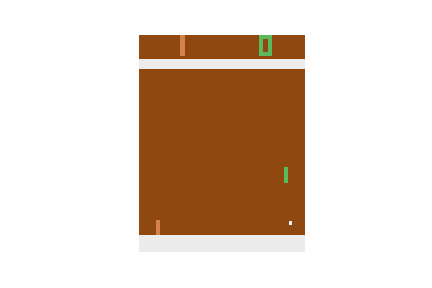
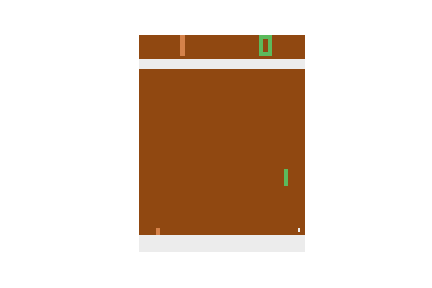
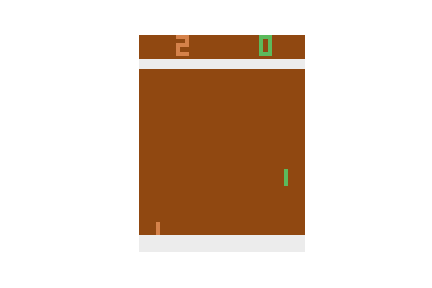
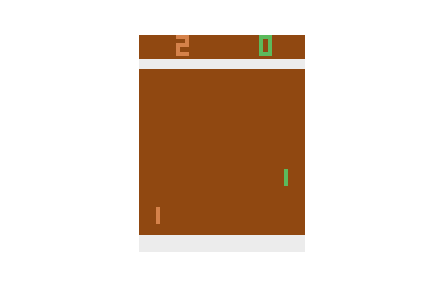
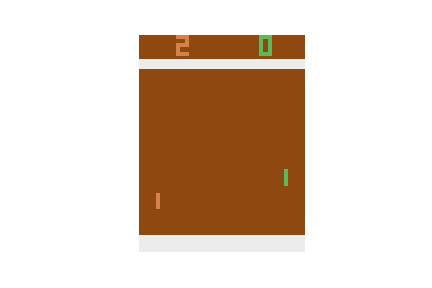
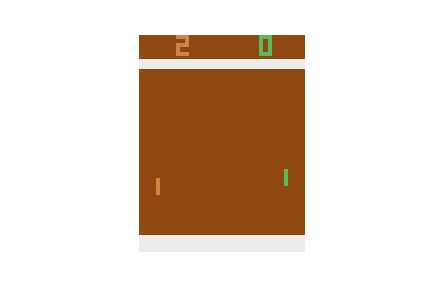
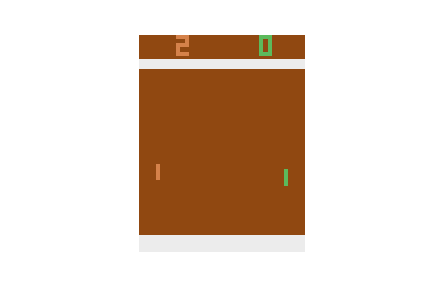
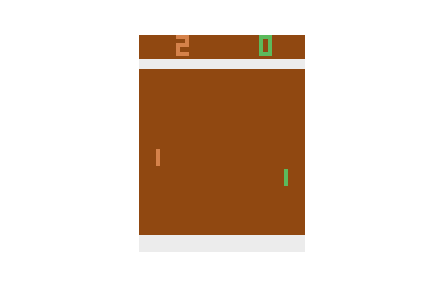
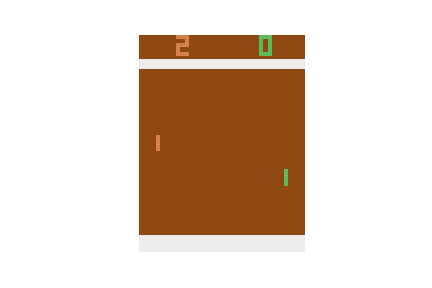
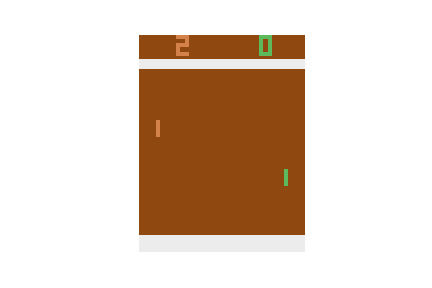
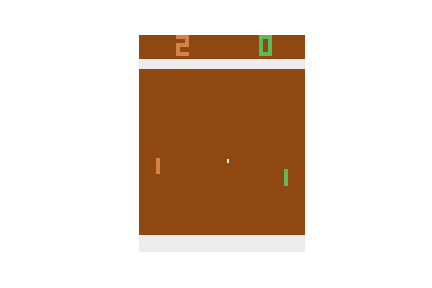
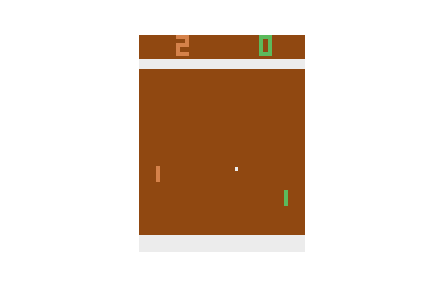
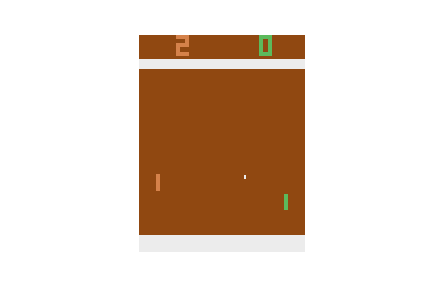
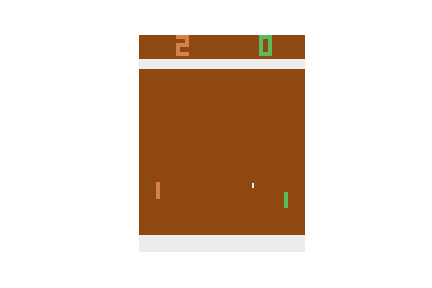
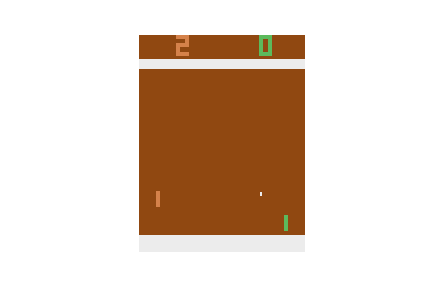
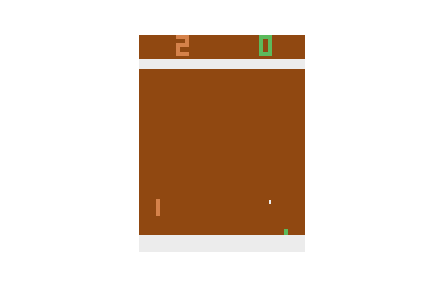
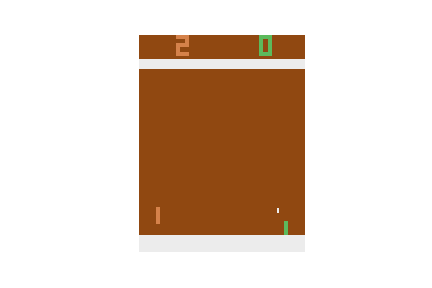
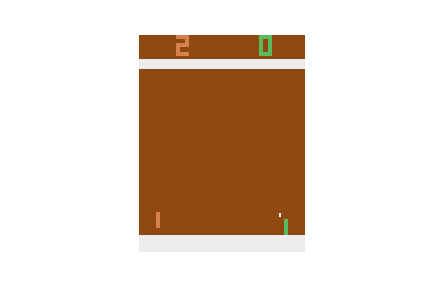
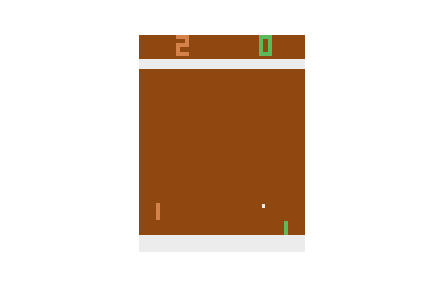
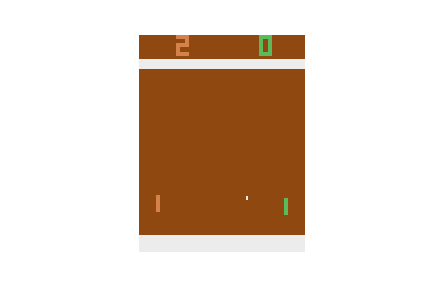
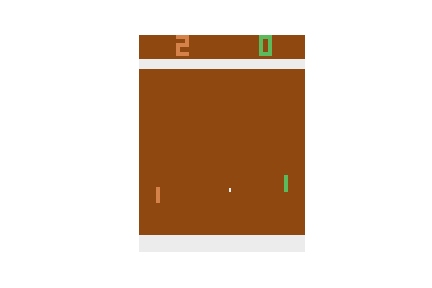
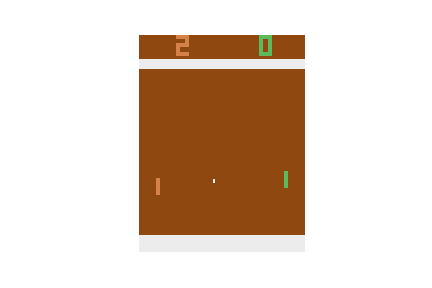
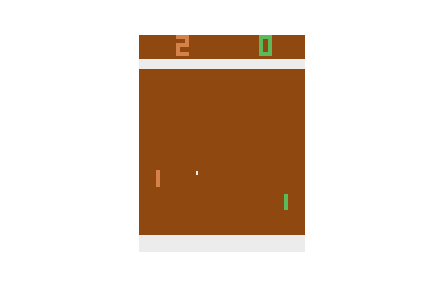
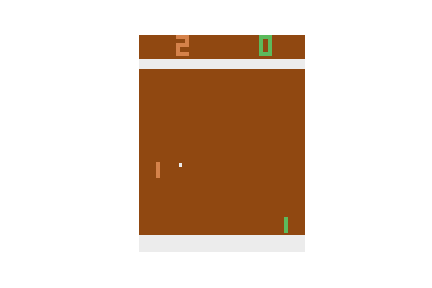
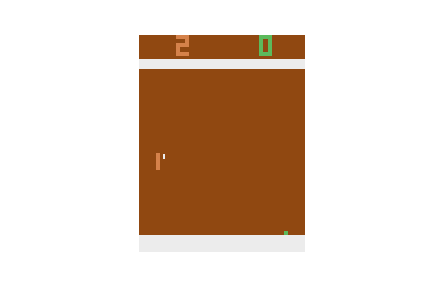
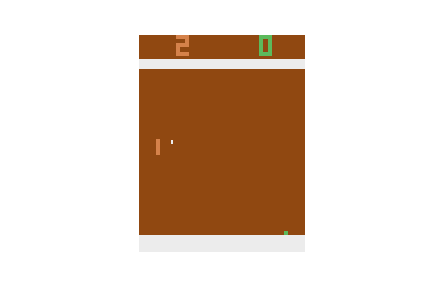
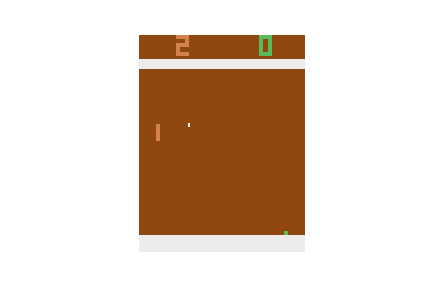
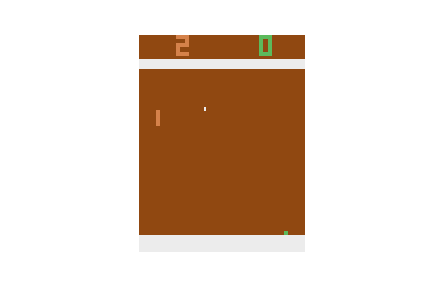
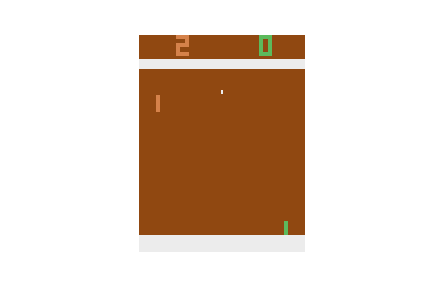
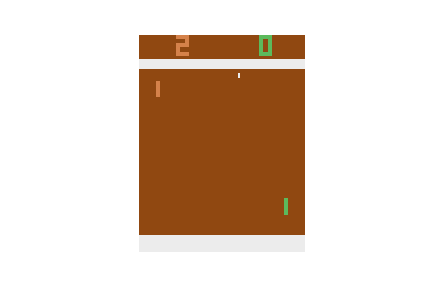
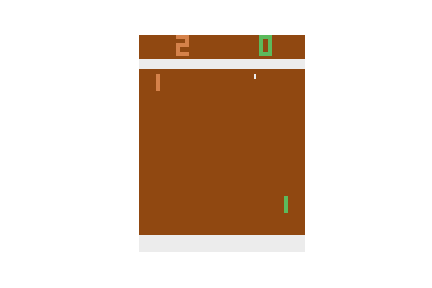
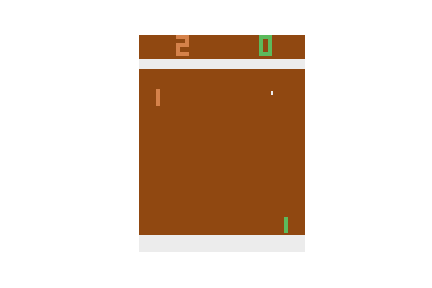
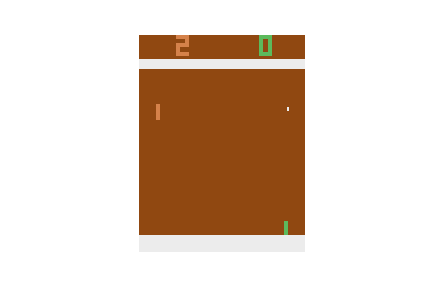
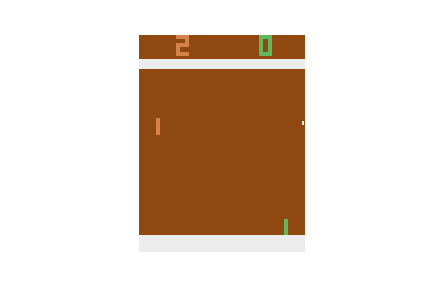
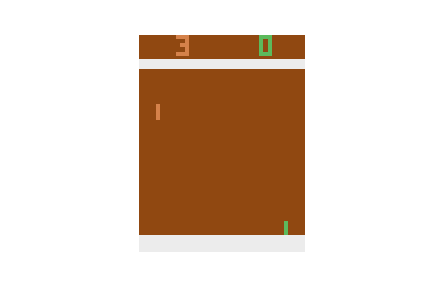
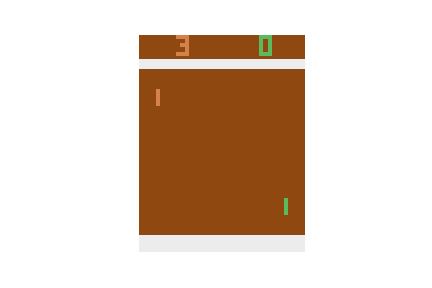
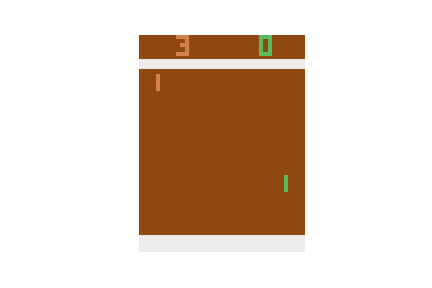
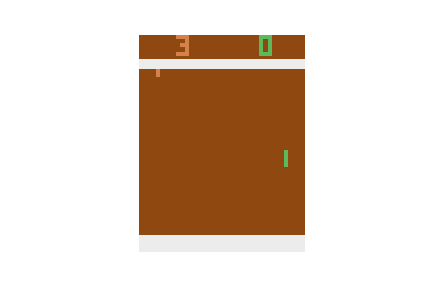
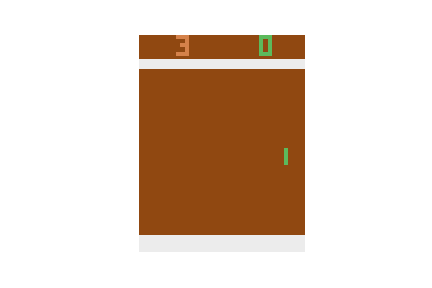
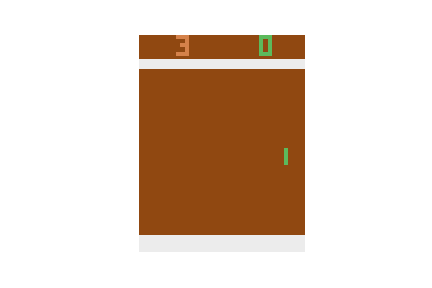
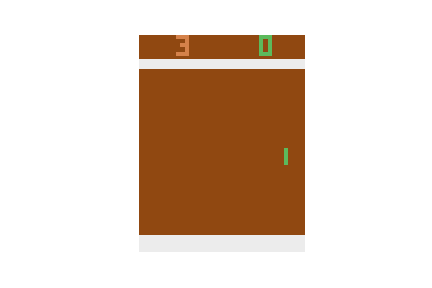
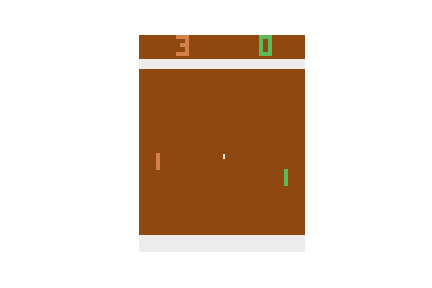
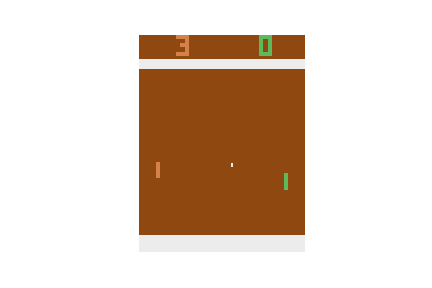
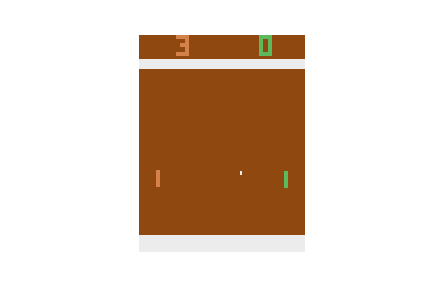
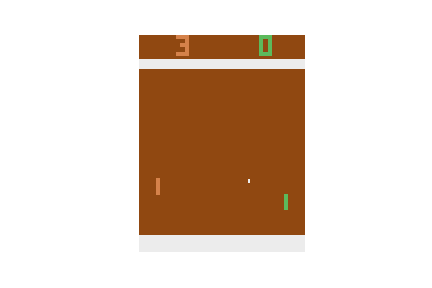
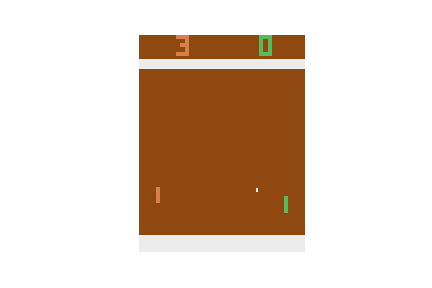
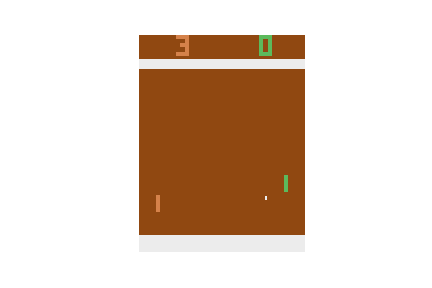
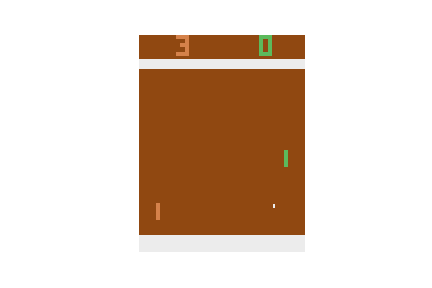
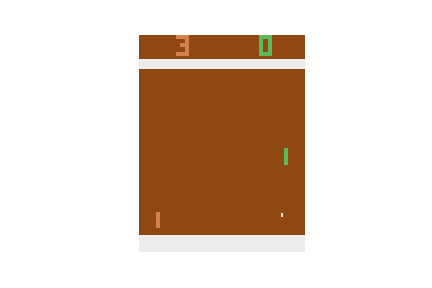
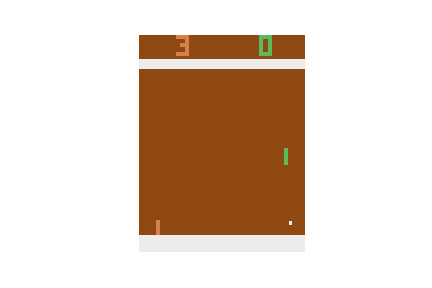
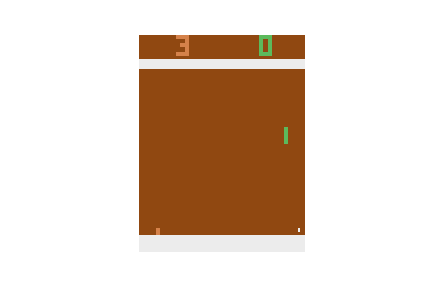
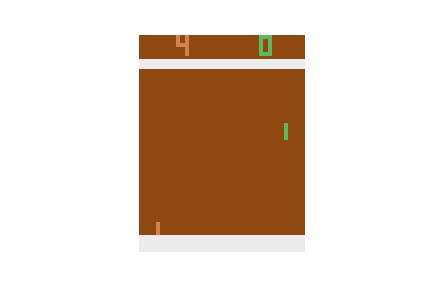
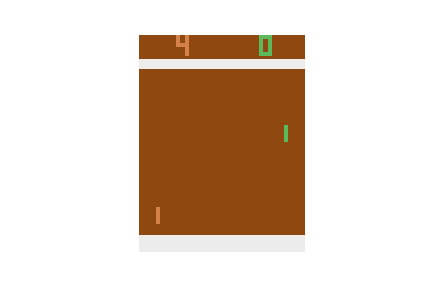
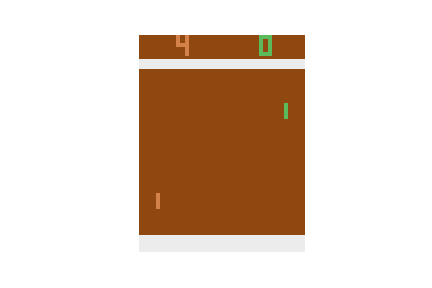
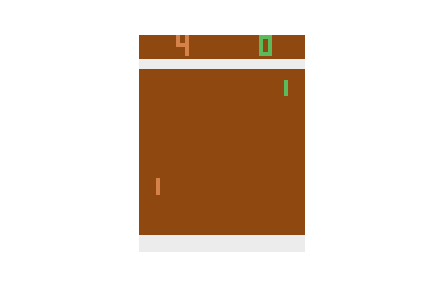
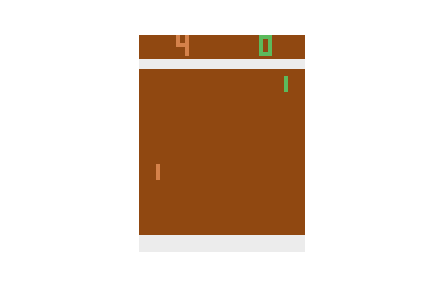
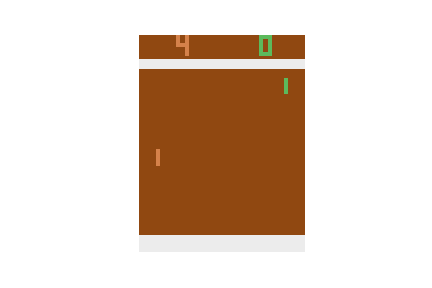
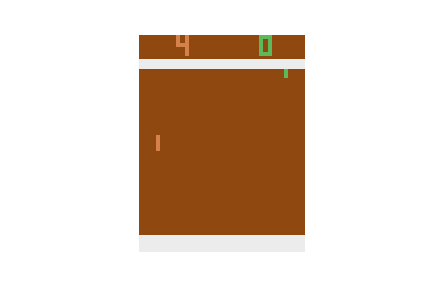
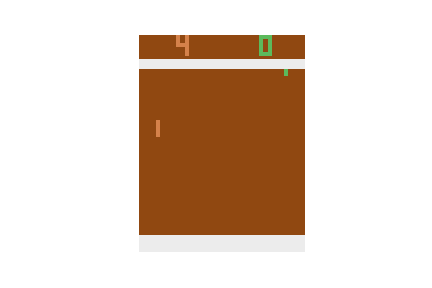
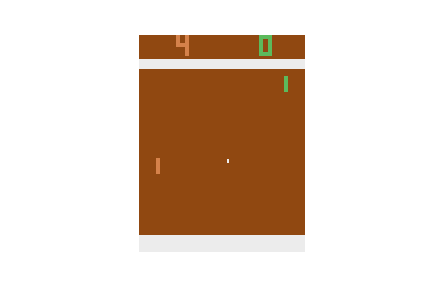
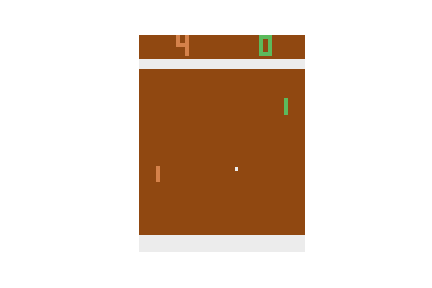
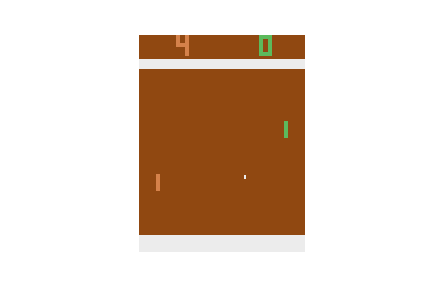
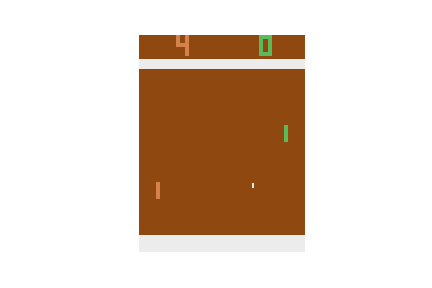
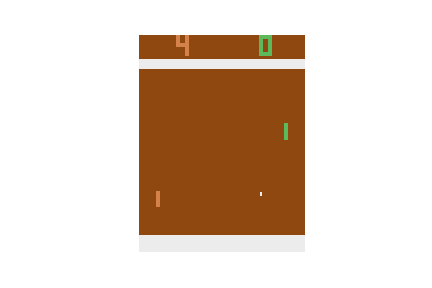
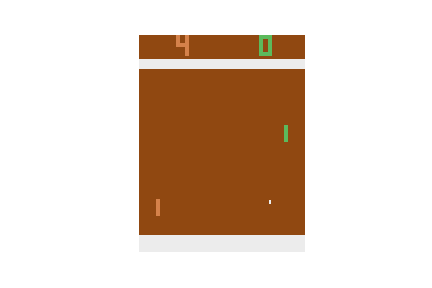
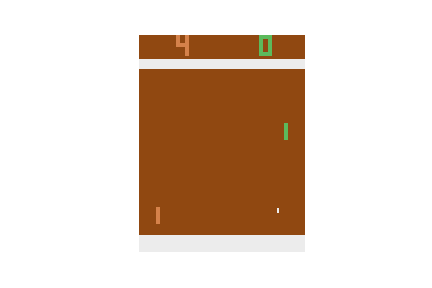
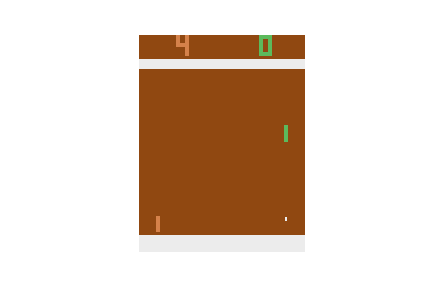
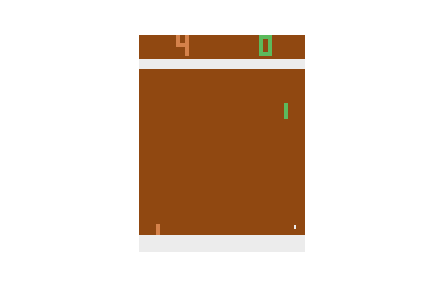
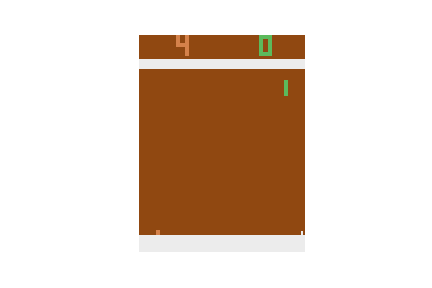
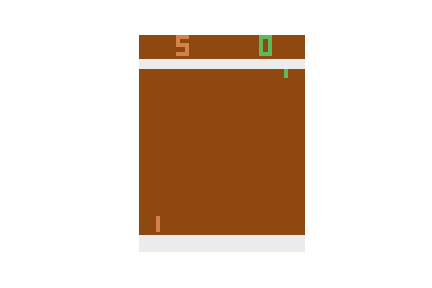
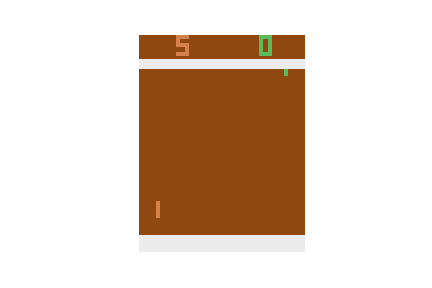
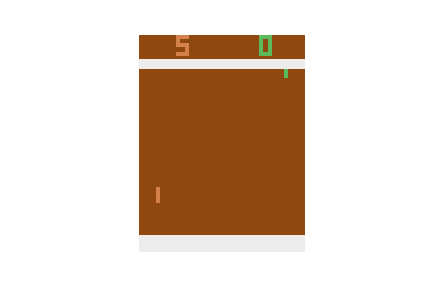
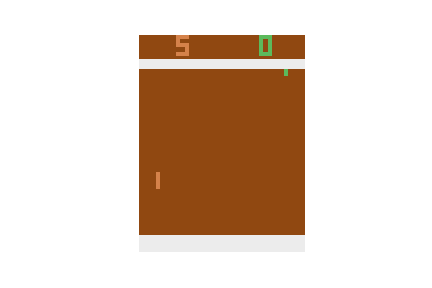
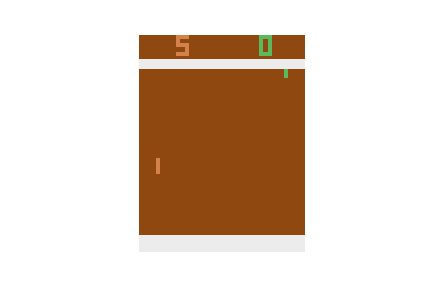
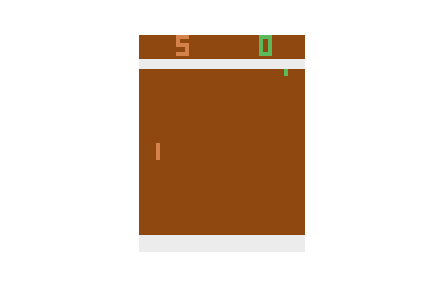
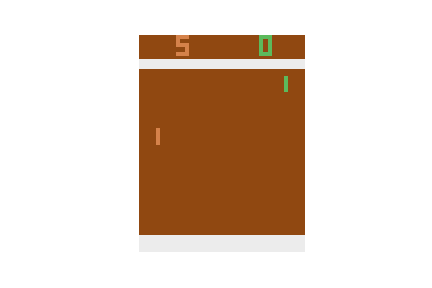
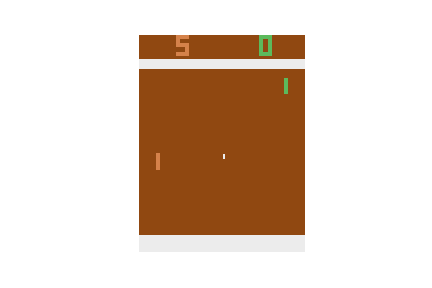
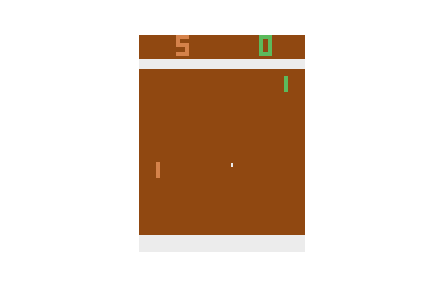
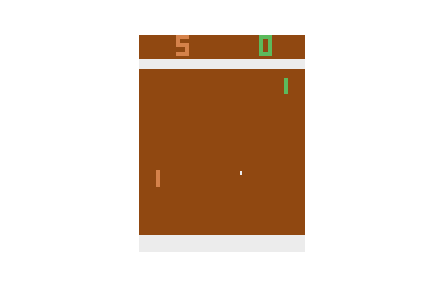
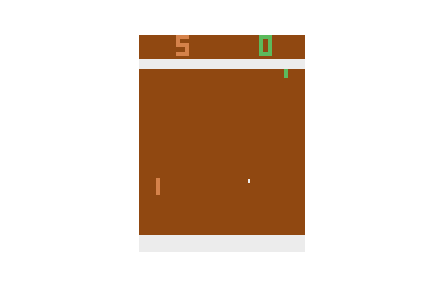
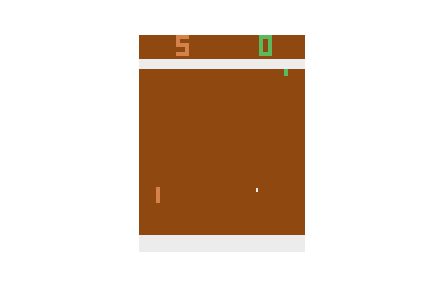
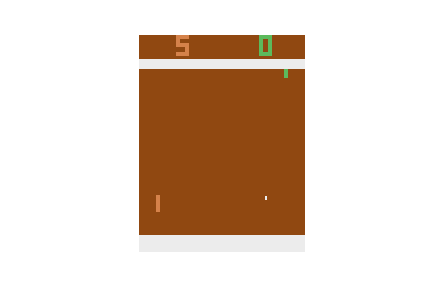
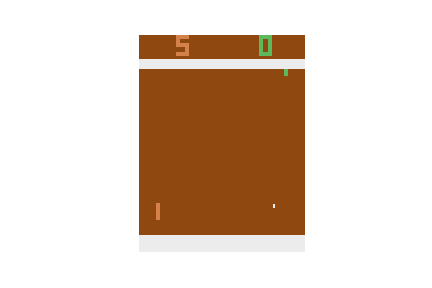
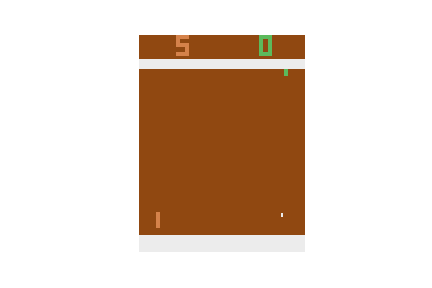
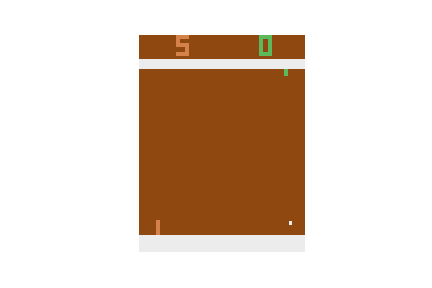
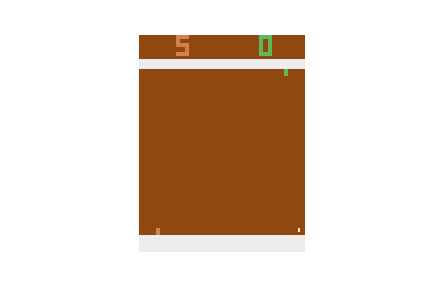
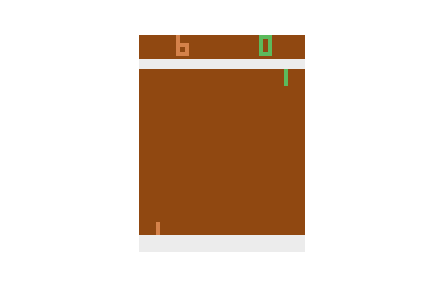
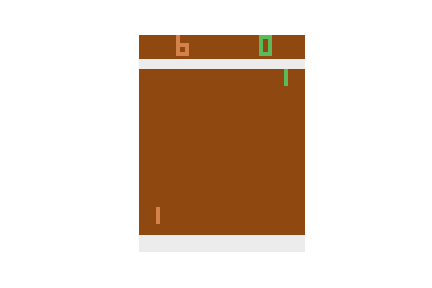
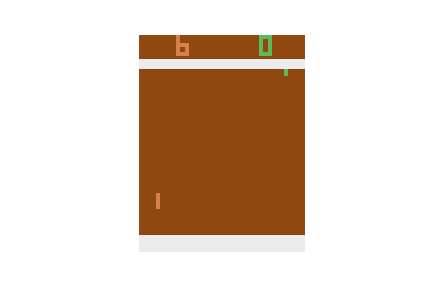
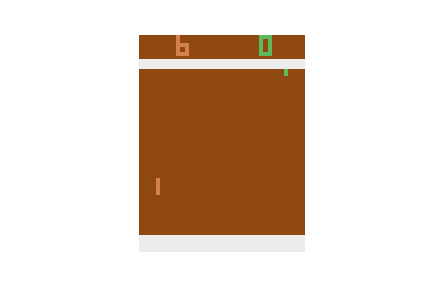
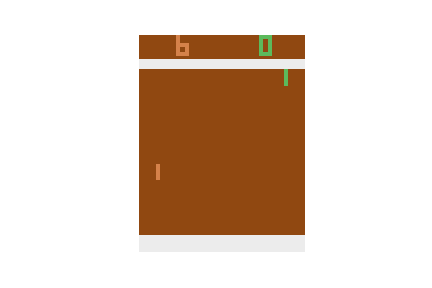
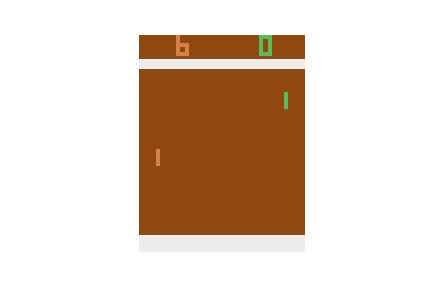
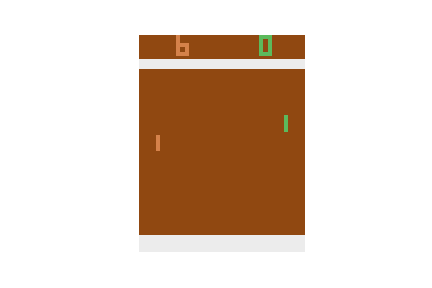
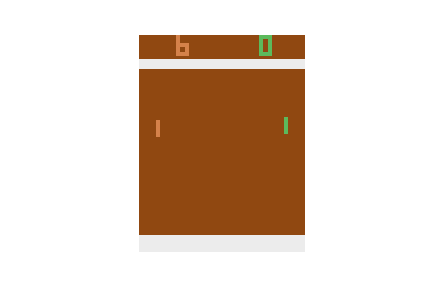
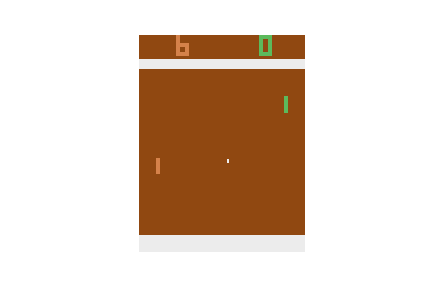
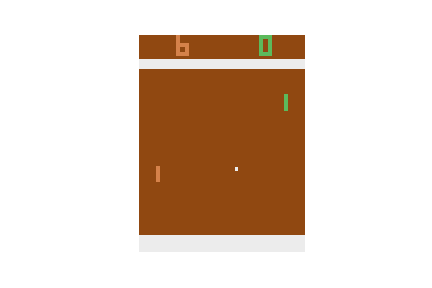
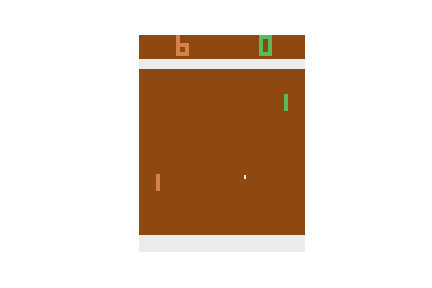
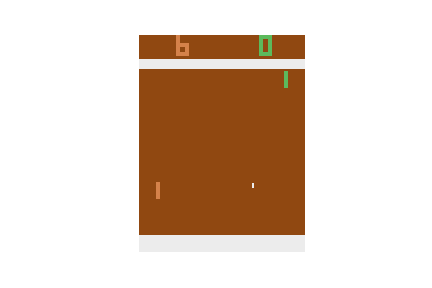
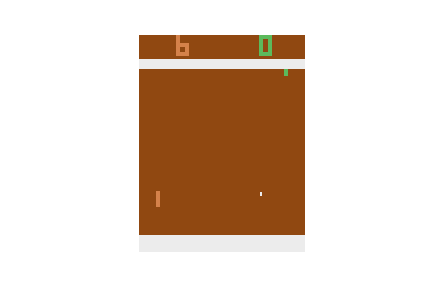
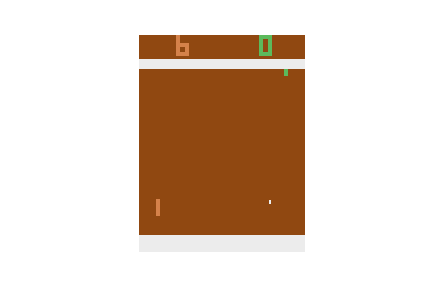
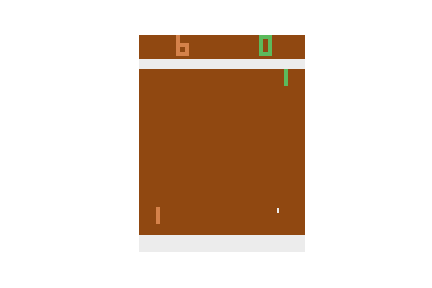
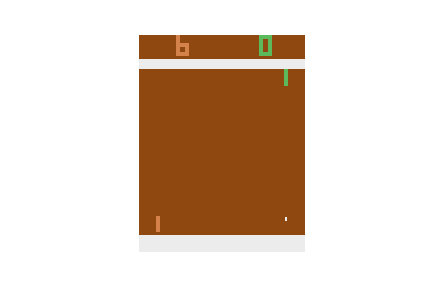
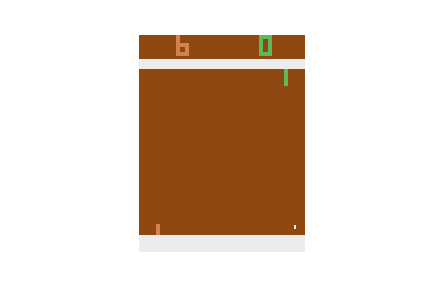
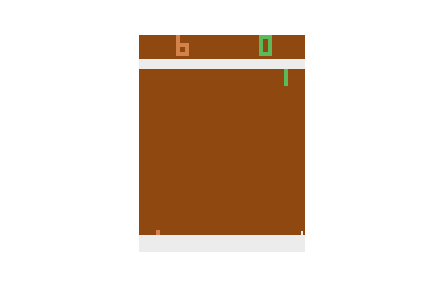
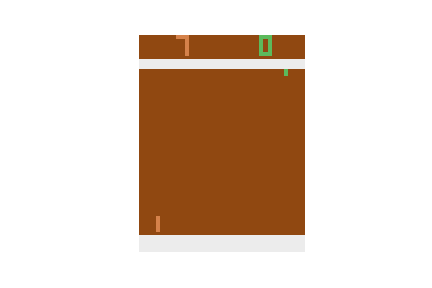
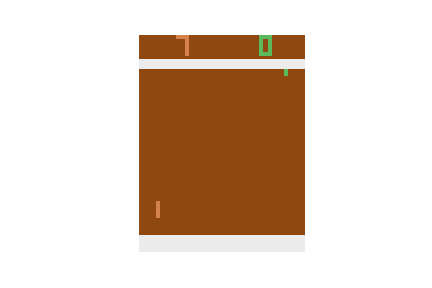
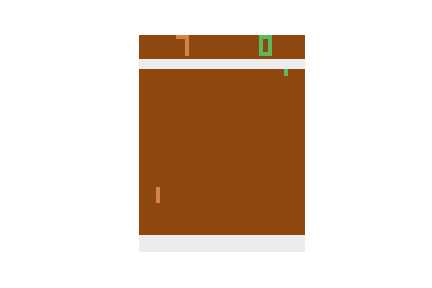
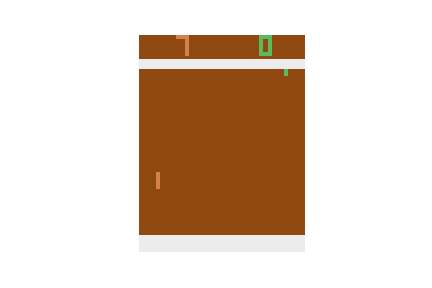
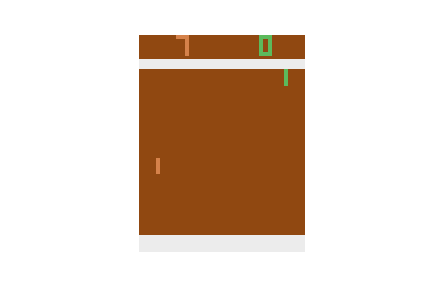
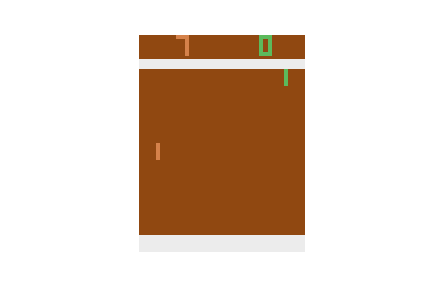
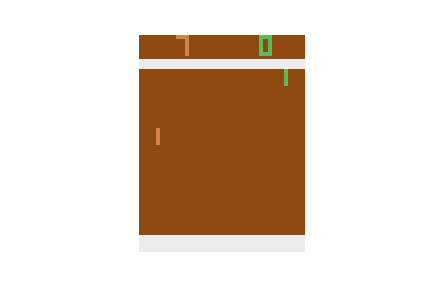
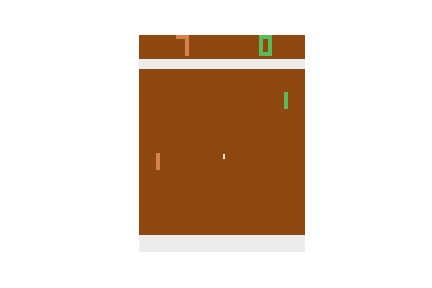
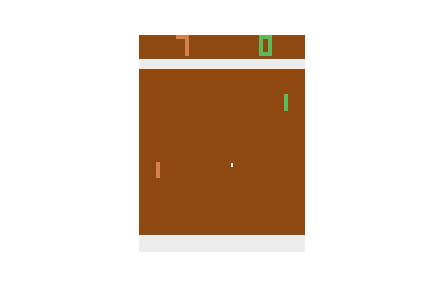
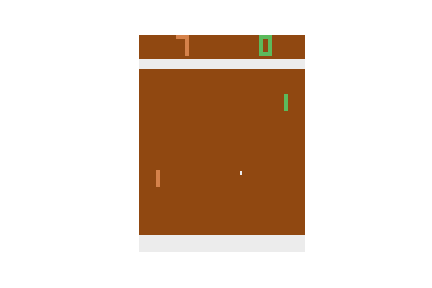
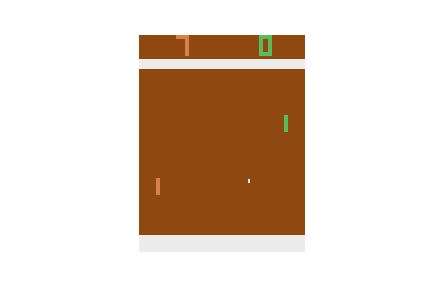
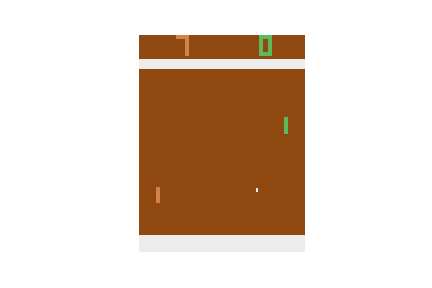
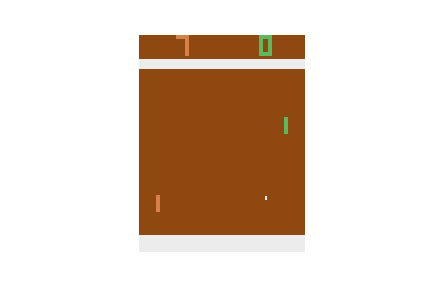
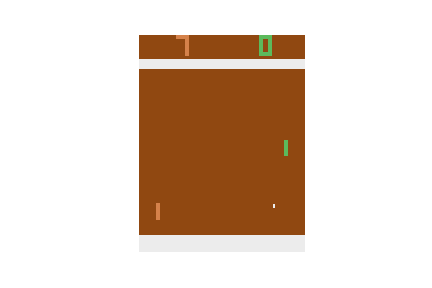
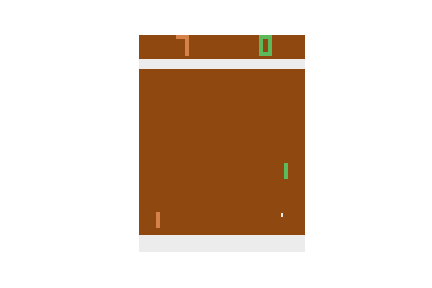
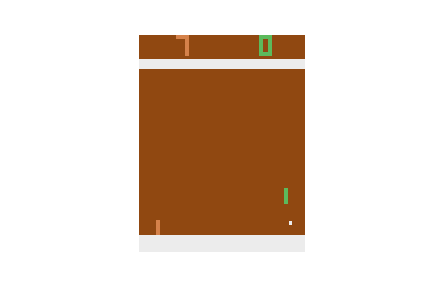
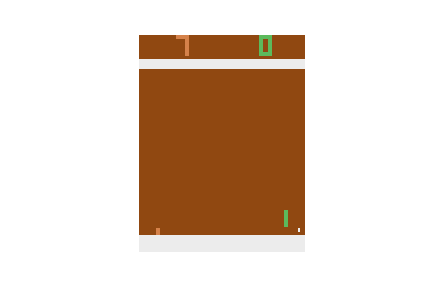
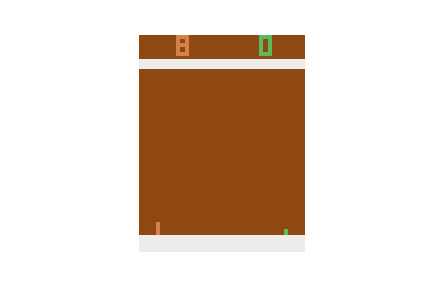
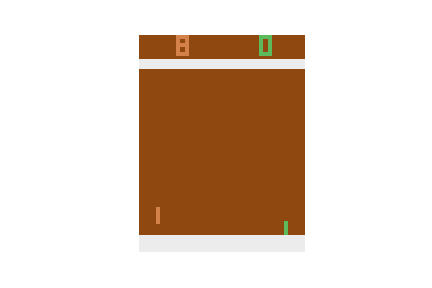
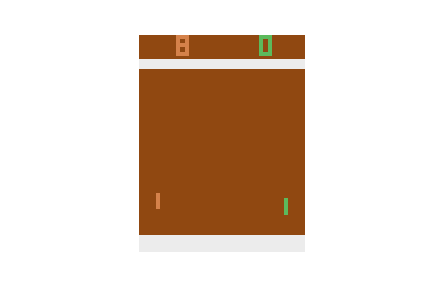
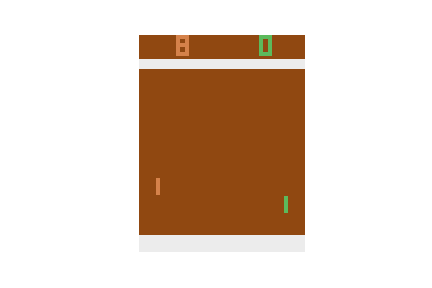
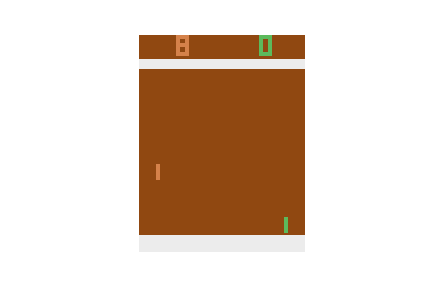
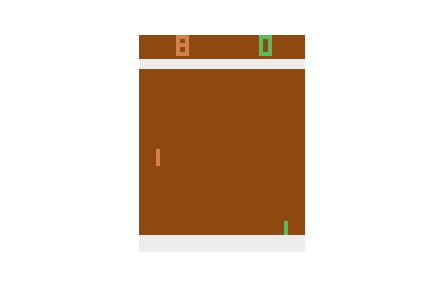
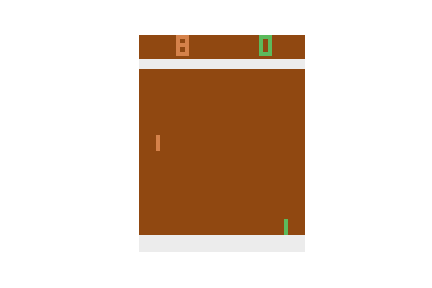
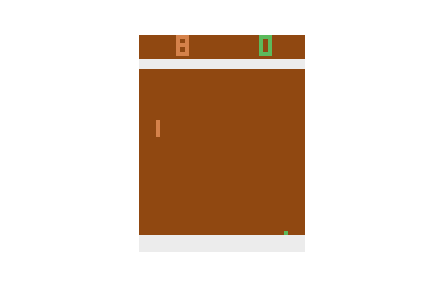
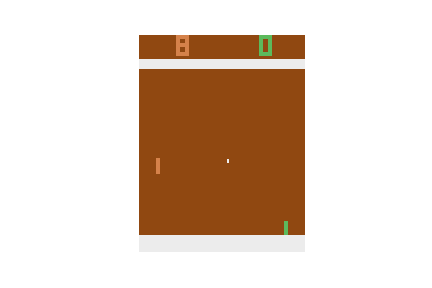
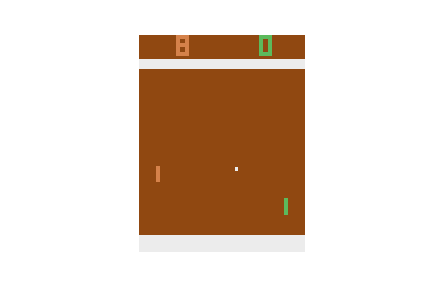
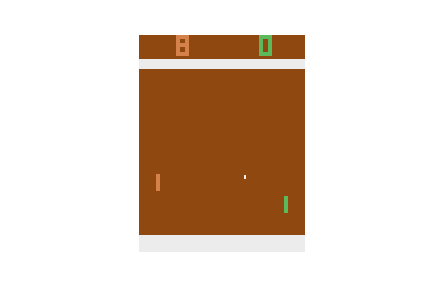
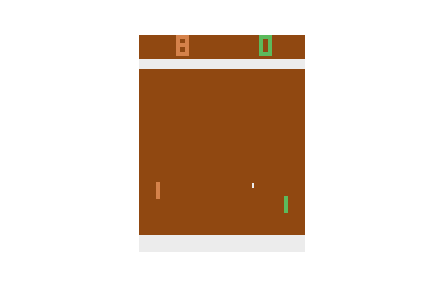
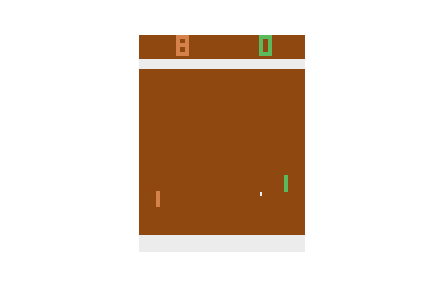
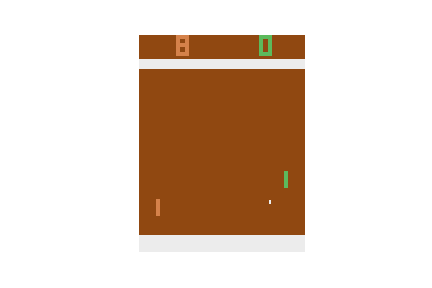
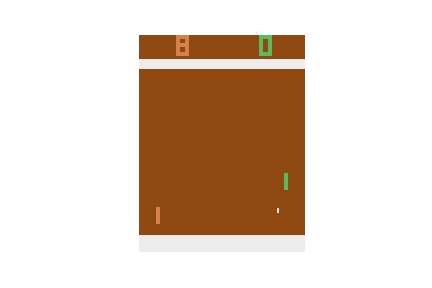
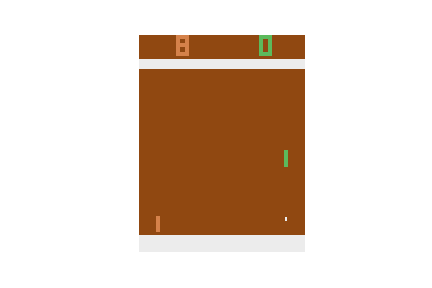
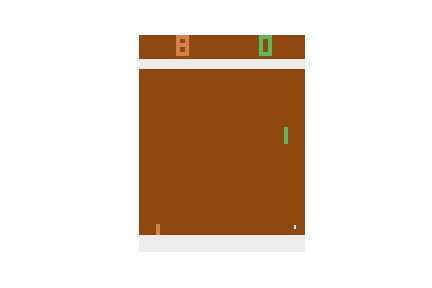
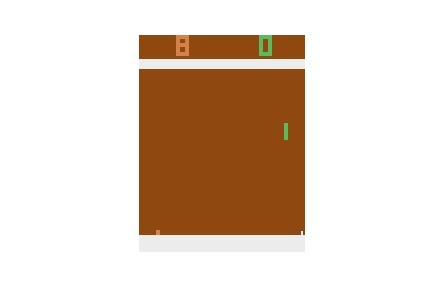
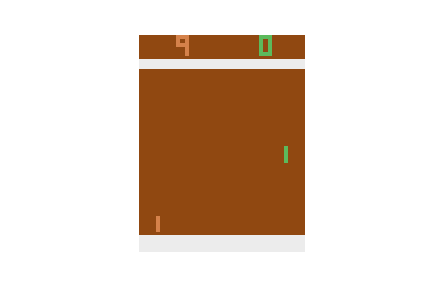
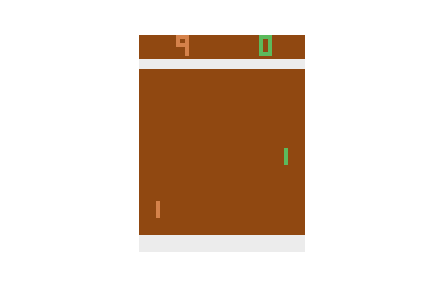
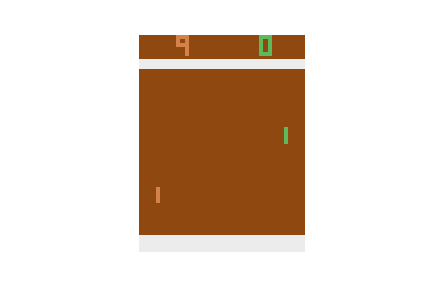
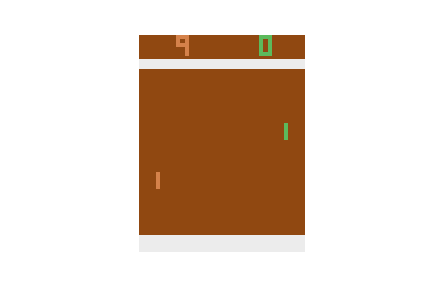
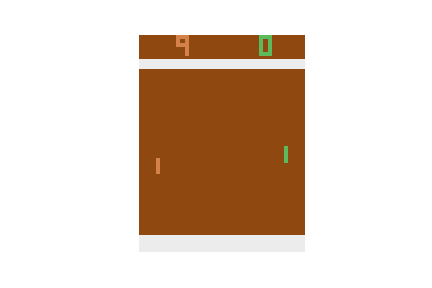
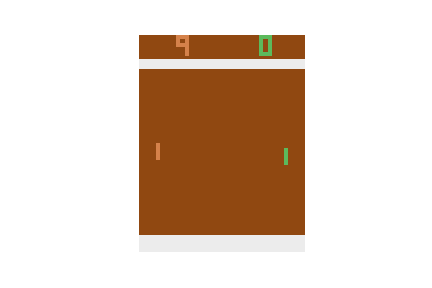
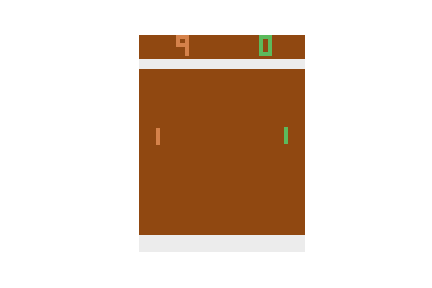
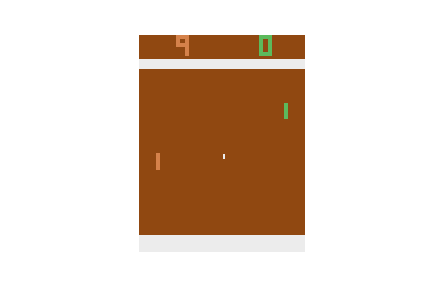
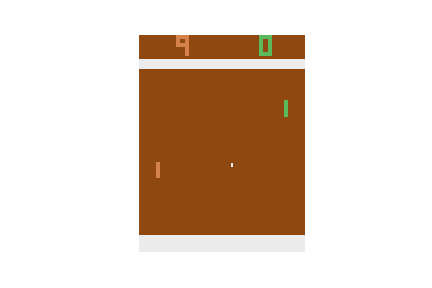
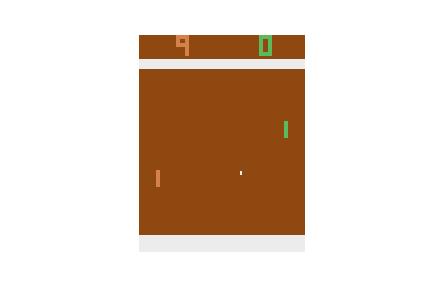
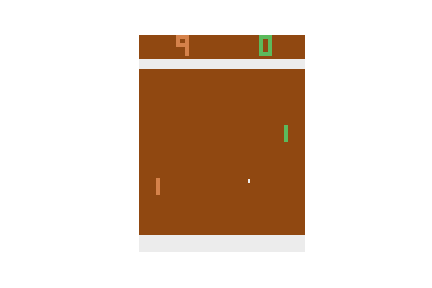
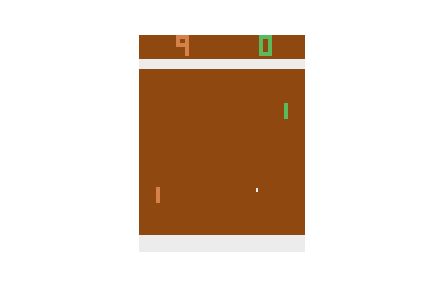
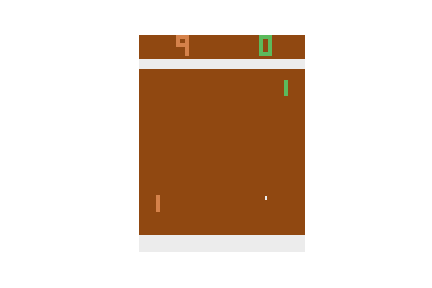
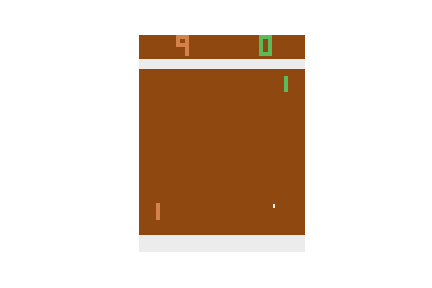
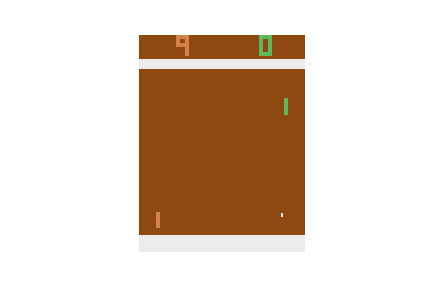
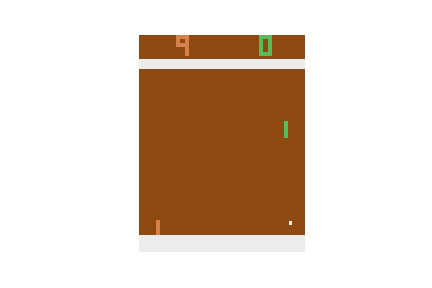
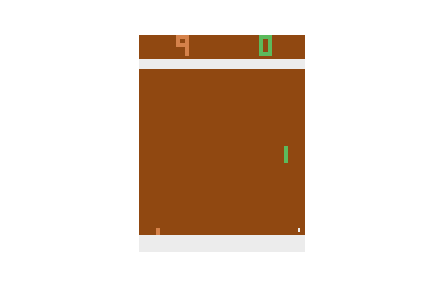
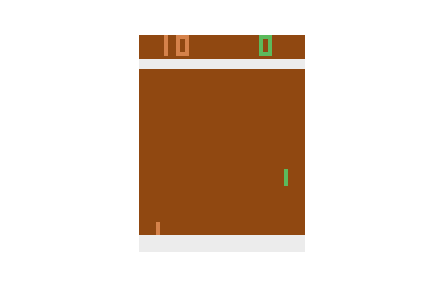
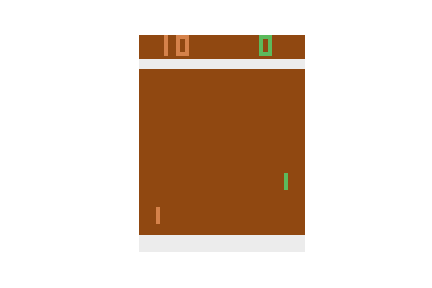

In [20]:
pong_utils.play(env, policy, time=200) 

In [22]:
# save your policy!
#torch.save(policy, 'PPO.policy')

# load policy if needed
#policy = torch.load('PPO.policy')

# try and test out the solution 
# make sure GPU is enabled, otherwise loading will fail
# (the PPO verion can win more often than not)!
#
policy_solution = torch.load('PPO_solution.policy')
pong_utils.play(env, policy_solution, time=2000) 

/Users/parksoy/anaconda3/envs/drlnd/lib/python3.6/site-packages/torch/serialization.py:367: SourceChangeWarning: source code of class 'pong_utils.Policy' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


AttributeError: module 'torch._C' has no attribute '_cuda_getDevice'